<a href="https://colab.research.google.com/github/estellasouza/SeoulBikeDemand_MachineLearning/blob/main/SeoulBikeDemand_MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem definition and set up

## Problem description

Rental bikes are available in many urban cities around the world. Their availability can improve mobility issues in highly populated cities.

In order to provide a reliable bike sharing service, it is necessary to understand the demand for bikes over time. In particular, we want to predict the number of bikes required to address the demand over each day, based on dependencies of demand that might exist (e.g., weather, season, time).


## Initial hypotheses

An initial qualitative analysis would suggest that we should expect to find evidence for the following:


* There is an **positive trend** for rented bikes for the bike sharing market as a whole (https://www.statista.com/statistics/868126/global-bikesharing-market-size/). Therefore, we expect the number of rented bikes required for a steady supply of service to increase over time.
* There is a **seasonal dependency** on the demand for bikes do to changes in seasonal patterns (e.g., higher during summer and lower during winter), in particular in regions with large seasonal variations (https://weatherspark.com/y/142033/Average-Weather-in-Seoul-South-Korea-Year-Round). Therefore, we expect the demand to modulate (i.e., sin function) over the year.
* There are **weather-based daily and hourly fluctuations** on the number of bikes required due to fluctuations on weather in addition to the seasonal trends, e.g., heavy rain, too high temeperatures, too high humidity, heavy snow accumulation, strong winds, etc.
* There is a **hour of the day dependency** in the demand of bikes, e.g., higher demand during rush hour.
* There is a **day of the week and holiday dependencies** in the demand of bikes that could indicate main use of bikes, e.g. transportation, work, leasure, etc.

The main question we want to answer with this model is **how many bikes do we need to supply each hour of each day to address the demand changes.**
This will be, therefore, a regression problem.



## Data selection

The data selected provides hourly data of the numbers of bikes rented in Seoul, South Korea, and multiple weather mearurements in the city. This should allow us to explore the different initial hypotheses that were described above.

### Importing necessary libraries for data explorarion and modeling.

In [ ]:
# Configure to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For data preparation: scaling & encoding
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import  LabelEncoder

# For data preparation: train/test split & cross-validation
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# For parameter tunning
from sklearn.model_selection import GridSearchCV

# For feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

# Metrics to be used
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# For creation of pipelines
from sklearn.pipeline import Pipeline

# For Adversarial Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# Regression algorithms
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Ensemble libraries
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


### Load Data

In [ ]:
# Loading data from github repository

# url with location of data
url = "https://raw.githubusercontent.com/estellasouza/SeoulBikeDemand_MachineLearning/main/SeoulBikeData.csv"

# Reading CSV file
dataset = pd.read_csv(url, encoding='unicode_escape')

# Printing first 5 lines to verify the attributes
dataset.head()

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

In [ ]:
# Since the data is a time series, verify the end of the data set as well (last 5 entries)
dataset.tail()

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
8755  30/11/2018               1003    19              4.2           34   
8756  30/11/2018                764    20              3.4           37   
8757  30/11/2018                694    21              2.6           39   
8758  30/11/2018                712    22              2.1           41   
8759  30/11/2018                584    23              1.9           43   

      Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
8755               2.6              1894                      -10.3   
8756               2.3              2000                       -9.9   
8757               0.3              1968                       -9.9   
8758               1.0              1859                       -9.8   
8759               1.3              1909                       -9.3   

      Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons  \
8755                      0.0           0.0            0.0  Autumn   
8756                      0.0           0.0            0.0  Autumn   
8757                      0.0           0.0            0.0  Autumn   
8758                      0.0           0.0            0.0  Autumn   
8759                      0.0           0.0            0.0  Autumn   

         Holiday Functioning Day  
8755  No Holiday             Yes  
8756  No Holiday             Yes  
8757  No Holiday             Yes  
8758  No Holiday             Yes  
8759  No Holiday             Yes

In [ ]:
# Checking the number of entries, columns and their indeces, the data types, and any number of null count per column
dataset.info()
dataset.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

(8760, 14)

Attribute information.

*  Date: date of rented bikes (dd/mm/yyyy)
*  Rented Bike Count: number of bikes rented at each hour (integer) - target
*  Hour: hour of the day (integer - 0 to 23)
*  Temperature (°C): temperature in Celsius (float)
*  Humidity (%): humidity measurement in % (integer)
*  Windspeed (m/s): wind speed in meters/second (float)
*  Visibility (10m): visibility within a 10m range (integer)
*  Dew point temperature (°C): temperature of dew point - dependent on temperature and relative humidity (float)
*  Solar radiation (MJ/m2): based on solar exposure in MJ/m2 (float)
*  Rainfall (mm): amount of rain fall in mm (float)
*  Snowfall (cm): amount of snow fall in cm (float)
*  Seasons: Winter, Spring, Summer, Autumn (category)
*  Holiday: if day is considered a holiday - Holiday, No holiday (category)
*  Functional Day: if service is functioning - Yes, No (category)

**Data structure observations:**


* Time series containing 1 year of data (12/01/2017 to 11/30/2018), possibly restricting conclusive results on the seasonality analysis
* No missing values (null values) - no data imputation needed
* Hourly data
* 14 total columns
 * 2 columns for time stamp (Date & Hour)
 * 11 columns for attributes: 8 numerical weather-based + 3 categorical (Seasons, Holiday, and Functioning Day)
 * Target column: Rented Bike Count



# Data Preparation

## Initial data preparation

During this first part of the data processing, we will focus on cleaning the data set:
  * Ensure "Date" format is clear (format will not be mixed up)
  * Rename some of the columns for simplicity
  * Remove any unnecessary raw data (including instances and features)






In [ ]:
# Modifying the format of the date for more clarity
dataset['Date'] = pd.to_datetime(dataset.Date, format='%d/%m/%Y') # day/month/year format

# Renaming some columns
dataset.rename(columns={'Rented Bike Count':'Bike_Count',
                        'Temperature(°C)':'Temperature',
                        'Humidity(%)':'Humidity',
                        'Wind speed (m/s)':'Wind',
                        'Visibility (10m)':'Vis',
                        'Dew point temperature(°C)':'Dew_temp',
                        'Solar Radiation (MJ/m2)':'Solar_rad',
                        'Rainfall(mm)':'Rain',
                        'Snowfall (cm)':'Snow',
                        'Functioning Day':'Functioning'
                        },inplace=True)

We want to make sure that no relevant information is provided for the days tagged as "No" under the "Functioning Day" column.

In [ ]:
# Series of the number of rented bikes for non-functioning days
dataset_nofunc = dataset.loc[dataset['Functioning']=='No', 'Bike_Count']

# Check if all numbers in "Bike_Count" are zero for the not-functioning days
if (dataset_nofunc==0).all():
  print("Confirmed that the number of bikes rented in non-functioning days is zero. \nThose entries can be removed.")
else:
  print("Further understanding needed for attribute 'Functioning Day'")

Confirmed that the number of bikes rented in non-functioning days is zero. 
Those entries can be removed.


In [ ]:
# Checking share of entries tagged as non-functioning

# Number of non-functioning days
print("Total days of data: ", dataset['Date'].nunique())
print("Non-functioning days: ", dataset.loc[dataset['Functioning']=='No', 'Date'].nunique())
print("Functioning days: ", dataset.loc[dataset['Functioning']=='Yes', 'Date'].nunique())

# Amount of data to be removed
nonFunc_entries = dataset.loc[dataset['Functioning']=='No','Date'].count()/dataset['Date'].count() *100
print("Percent of entries tagged as non-functioning: ", nonFunc_entries, "%")

# Removing unnecessary data entries (entries of non functioning days) and deleting the attribute 'Functioning'
dataset_clean = dataset[dataset['Functioning']=='Yes']#.reset_index(drop=True'
dataset_clean = dataset_clean.drop('Functioning', axis=1)

Total days of data:  365
Non-functioning days:  13
Functioning days:  353
Percent of entries tagged as non-functioning:  3.3675799086757987 %


Note that:
* there should be one day that has some entries tagged as non-functioning while others as functioning (353+13 = 366 and not 365)
* this should not have a significant impact in the daily distributions
* the amount of entries to be removed is small: ~3.4%


In [ ]:
# dataset_clean: cleaned version of the input data set
dataset_clean.head()

Date  Bike_Count  Hour  Temperature  Humidity  Wind   Vis  Dew_temp  \
0 2017-12-01         254     0         -5.2        37   2.2  2000     -17.6   
1 2017-12-01         204     1         -5.5        38   0.8  2000     -17.6   
2 2017-12-01         173     2         -6.0        39   1.0  2000     -17.7   
3 2017-12-01         107     3         -6.2        40   0.9  2000     -17.6   
4 2017-12-01          78     4         -6.0        36   2.3  2000     -18.6   

   Solar_rad  Rain  Snow Seasons     Holiday  
0        0.0   0.0   0.0  Winter  No Holiday  
1        0.0   0.0   0.0  Winter  No Holiday  
2        0.0   0.0   0.0  Winter  No Holiday  
3        0.0   0.0   0.0  Winter  No Holiday  
4        0.0   0.0   0.0  Winter  No Holiday

## Exploratory data analysis

The goal of this section is to:
  * Learn how data is divided and the numerical vs categorical features provided, and how they change over time
  * Determine what attributes will be useful in understanding the data and what information will still be needed
  * Refine the initial hypotheses presented earlier on

Let's break down the different types of columns that were provided in this data set to better understand how to prepare them for the modeling steps. But first, let's make a copy of the data set, so that any change can be kept within this exploratory section for now.

In [ ]:
df_explore = dataset_clean.copy()

### A. Time series columns: "Date" and "Hour"

* We can refine the information on the date by breaking it down in day, month, and year, as well as keep a tracker on the days since the start of data collection. These numerical features can help on identifying time dependencies.
* It is possible to identify the day of the week based on the date. This could help in identifying weekly trends.


In [ ]:
# Exploring impact of more refined time information in the data set

# Break down 'Date' into 'month_year' - to allow correct positioning of monthly data, since dataset starts in December
df_explore['month_year'] = df_explore['Date'].dt.to_period('M')

# Get Month number and day (numerical)
df_explore['month'] = df_explore['Date'].dt.month
df_explore['day'] = df_explore['Date'].dt.day

# Get day of the week (categorical)
df_explore['week_day'] = df_explore['Date'].dt.day_name()

# Get order of days (starts in first day recorded - 2017/12/01)
df_explore['date_order'] = pd.to_datetime(df_explore['Date']).apply(lambda Date: Date.toordinal())
df_explore['date_order'] = df_explore['date_order']-df_explore['date_order'].min()

# Check updated dataframe
print("Number of functioning days: ", df_explore["date_order"].nunique())
df_explore.head()

Number of functioning days:  353


Date  Bike_Count  Hour  Temperature  Humidity  Wind   Vis  Dew_temp  \
0 2017-12-01         254     0         -5.2        37   2.2  2000     -17.6   
1 2017-12-01         204     1         -5.5        38   0.8  2000     -17.6   
2 2017-12-01         173     2         -6.0        39   1.0  2000     -17.7   
3 2017-12-01         107     3         -6.2        40   0.9  2000     -17.6   
4 2017-12-01          78     4         -6.0        36   2.3  2000     -18.6   

   Solar_rad  Rain  Snow Seasons     Holiday month_year  month  day week_day  \
0        0.0   0.0   0.0  Winter  No Holiday    2017-12     12    1   Friday   
1        0.0   0.0   0.0  Winter  No Holiday    2017-12     12    1   Friday   
2        0.0   0.0   0.0  Winter  No Holiday    2017-12     12    1   Friday   
3        0.0   0.0   0.0  Winter  No Holiday    2017-12     12    1   Friday   
4        0.0   0.0   0.0  Winter  No Holiday    2017-12     12    1   Friday   

   date_order  
0           0  
1           0  
2           0  
3           0  
4           0

Mean of date_order: 178.4
Median of date_order: 178.0
Standard deviation of date_order: 104.7
Mean of Hour: 11.5
Median of Hour: 12.0
Standard deviation of Hour: 6.9


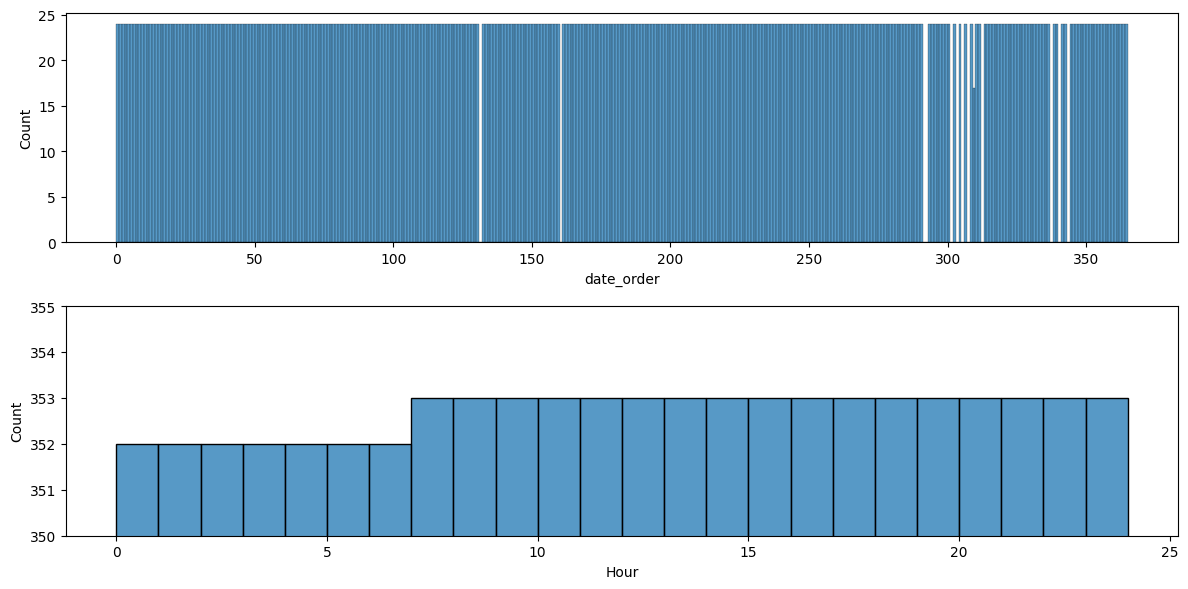

In [ ]:
# Time Series - distribution of entries

# Set up figure
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6), dpi=100)

# Variables that will be plotted: days from start of set (Dec 1st 2017) and hour of the day
time_features = ['date_order','Hour']

# Looping over the time features to be plotted
for i in range(len(time_features)):
  bin_range = (df_explore[time_features[i]].min(),df_explore[time_features[i]].max()+1) # bin range for the plot
  sns.histplot(data=df_explore, x=time_features[i], binwidth=1, binrange=bin_range, ax=axs[i], palette="tab10") # Histogram with binwidth of 1 day/hour: 24/353 entries per bin expected
  print("Mean of %s: %0.1f" % (time_features[i],df_explore[time_features[i]].mean()))
  print("Median of %s: %0.1f" % (time_features[i],df_explore[time_features[i]].median()))
  print("Standard deviation of %s: %0.1f" % (time_features[i],df_explore[time_features[i]].std()))

plt.ylim(350,355) # zooming to check missing hours
plt.tight_layout()

As mentioned before, we can see above that one day doesn't have data for the full day (due to some hours being removed as non-functioning). It seems like there was a period of 7 hours that did not function during that day.

Note that there is somewhat of a cluster of non-functioning days close to day 300 that seem to provide a small skew to the distribution. We will later evaluate how the model performs in the test data set close to that region to determine if the model was drastically affected.

### B. Categorical features: "Seasons", "Holiday", "week_day"

  * Seasons:
    * Since there is one year of data, the dataset spans all four seasons: Winter, Spring, Summer, Autumn.
    * The dependency of the number of rented bikes on the season is likely to be large. However, the month might provided more refined information, since trends might change within one season, and therefore the seasons feature would not be needed.
  * Holiday
    * Days are categorized in Holiday or No Holiday - Holidays will likely constitute a very small part of the data.
  * Day of the Week: "Monday", "Tuesday", ..., "Sunday"
    * Enabling easier tracking of daily trends based on demand on different days of the week.

Encoding will be needed during the feature engineering step.



In [ ]:
# Determining percentage of data in categories

# Holiday
print("###### HOLIDAY ######")
print("Share of Holiday/No Holiday in the data set (in %)")
print(df_explore.groupby('Holiday')['Date'].count()/df_explore['Date'].size *100, "\n")

# Seasons
print("###### SEASONS ######")
print("Share of Seasons categories in the data set (in %)")
print(df_explore.groupby('Seasons')['Date'].count()/df_explore['Date'].size *100, "\n")

# Days of the Week
print("###### WEEKDAY ######")
print("Share of Days of the Week categories in the data set (in %)")
print(df_explore.groupby('week_day')['Date'].count()/df_explore['Date'].size *100, "\n")



###### HOLIDAY ######
Share of Holiday/No Holiday in the data set (in %)
Holiday
Holiday        4.819846
No Holiday    95.180154
Name: Date, dtype: float64 

###### SEASONS ######
Share of Seasons categories in the data set (in %)
Seasons
Autumn    22.882457
Spring    25.516834
Summer    26.083875
Winter    25.516834
Name: Date, dtype: float64 

###### WEEKDAY ######
Share of Days of the Week categories in the data set (in %)
week_day
Friday       14.459539
Monday       14.743060
Saturday     14.376846
Sunday       14.459539
Thursday     14.176019
Tuesday      13.608978
Wednesday    14.176019
Name: Date, dtype: float64 



Given how the data is distributed by categories, we can see that:
* Holidays constitute only ~5% of the data, and therefore we should ensure we have enough samples in the training set to correctly model the demand during Holidays
* Autumn has less data than the other Seasons (~81 days instead of ~90), with a difference of ~10% in the number entries due to the removed non-functioning days that were closely clustered during Autumn
* The distribution of days of the week can be considered uniform for this data set


Let's visualize how the number of rented bikes is distributed over time (hourly, daily, monthly) by category:
* Holiday vs No Holiday
* Season  
* Day of the week

**Hourly Dependencies**

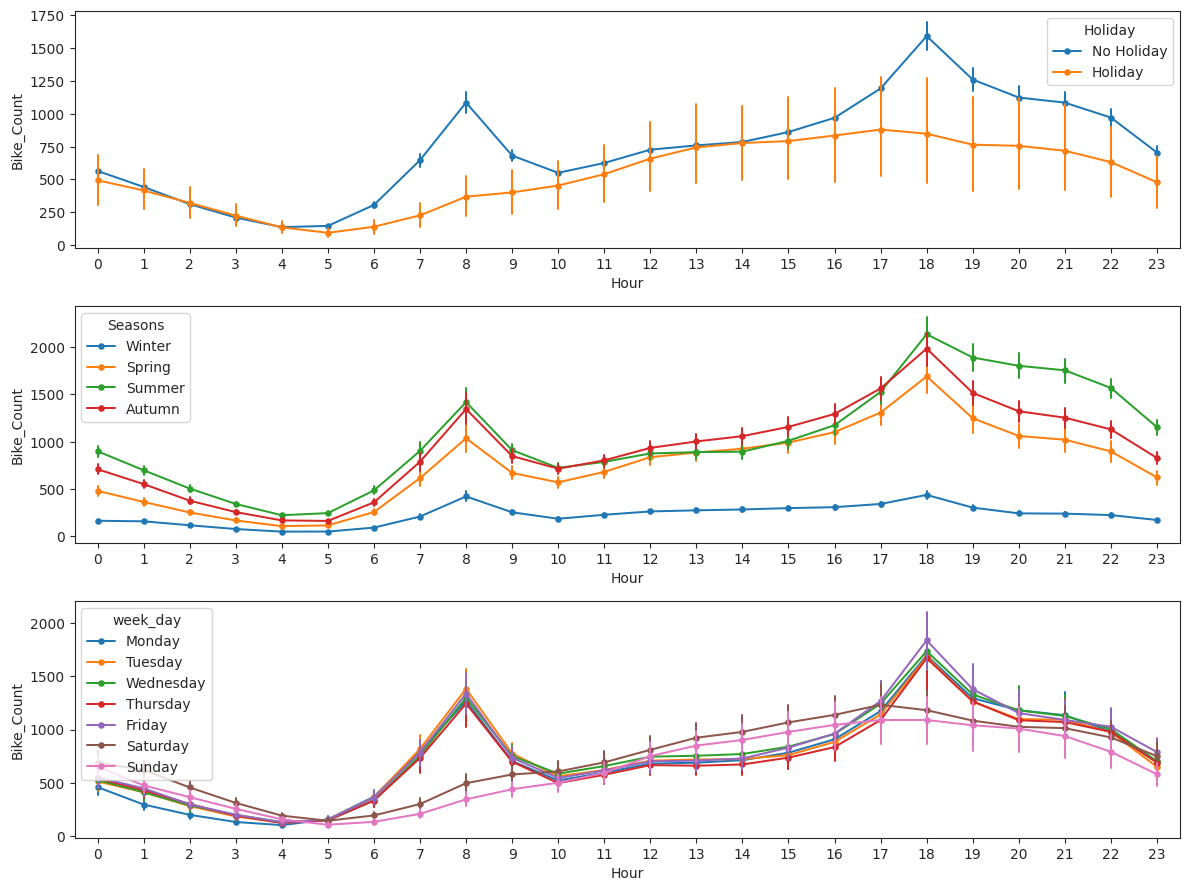

In [ ]:
# Distribution of total number of bikes per hour by category

# Seaborn style
sns.set_style("ticks")

# Setting order of days of the week to avoid alphabetical order
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set up figure and subplots
fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,9), dpi=100)

# Plot and arrange
with plt.rc_context({'lines.linewidth': 0.8}):
  sns.pointplot(data=df_explore, x="Hour", y="Bike_Count", ax=axs[0], hue="Holiday", palette="tab10")
  sns.pointplot(data=df_explore, x="Hour", y="Bike_Count", ax=axs[1], hue="Seasons", palette="tab10")
  sns.pointplot(data=df_explore, x="Hour", y="Bike_Count", ax=axs[2], hue="week_day", palette="tab10", hue_order=order)
plt.tight_layout()

We can observe different hourly patterns when breaking down the number of rented bikes by the categorical attributes.
* Peaks are observed at 8h and 18h, likely due to transportation to/from work (rush hour). This feature is NOT observed during Holidays and weekends. It is also less pronounced during Winter due to overall suppression of the bikes rented.
* There is a large suppression on the average number of bikes rented during the Winter across the entire day.
* The curve for Holidays is more similar to the weekend days, however let's confirm that it is not due to all holidays falling on the weekend during that year.
* It would be interesting to break down the same hourly distribution with the different months as the selected category to compare it to the Seasons, to confirm (or not) if the months can be used as a proxy for the Seasons.
* Since the distributions of the weekdays are closely matched, we can consider creating a new feature that labels the day as a weekday or a weekend (e.g. 'isWeekday'), in order to decrease the dimensionality when encoding this categorical feature.


Let's understand if the daily distribution is similar to that of weekends because they fall more often on weekends or if there is an intrinsic reason.

In [ ]:
# Checking Holidays distributed by day of the week

# Grouped data frame by week day
df_weekdayHoliday = df_explore.groupby('week_day')['Holiday'].value_counts().reset_index()

# Create pivot table for the sum of entries (hourly, 24 per day) in each day of the week for holidays and non holidays
table = pd.pivot_table(df_weekdayHoliday, values='count', index=['week_day'], columns=['Holiday'], aggfunc="sum")

# Add % values to the table
table['% Holiday'] = 100*table['Holiday']/(table['Holiday']+table['No Holiday'])
table['% NoHoliday'] = 100*table['No Holiday']/(table['Holiday']+table['No Holiday'])

table


Holiday    Holiday  No Holiday  % Holiday  % NoHoliday
week_day                                              
Friday          48        1176   3.921569    96.078431
Monday          72        1176   5.769231    94.230769
Saturday        24        1193   1.972062    98.027938
Sunday          72        1152   5.882353    94.117647
Thursday        48        1152   4.000000    96.000000
Tuesday         72        1080   6.250000    93.750000
Wednesday       72        1128   6.000000    94.000000

As seen above, most of the holidays do not fall on weekends. Therefore, the shape we observed above (of the Bike_Count over the hours of the day during Holidays), is not due to most Holidays falling on the weekend. It is likely due to customer behavior being intrinsically similar in Holidays and weekends (e.g., not work/study days).

Now, let's investigate the need for the 'Seasons' attribute: if it can be considered dependent on the time of the year.

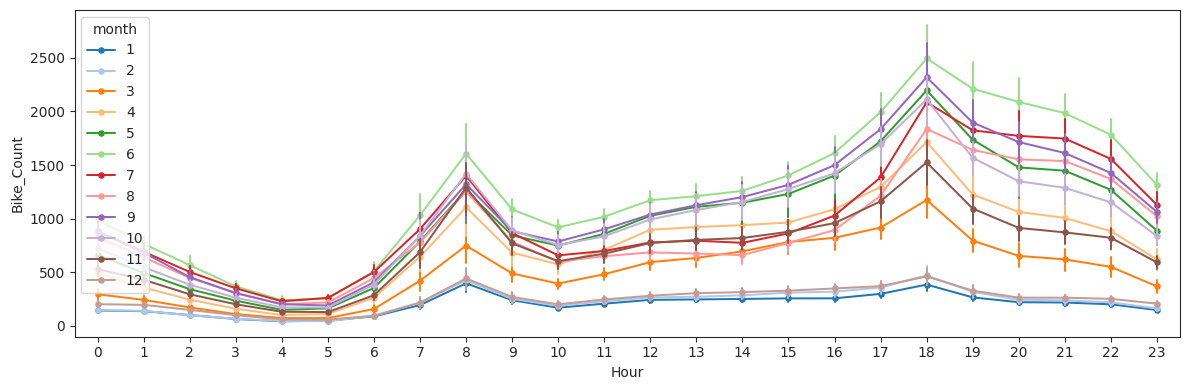

In [ ]:
# Distribution of total number of bikes per hour by month as proxy for season

# Seaborn style
sns.set_style("ticks")

# Set up figure
fig = plt.figure(figsize=(12,4))

# Plot and arrange
with plt.rc_context({'lines.linewidth': 0.8}):
  sns.pointplot(data=df_explore, x="Hour", y="Bike_Count", hue="month", palette="tab20")
plt.tight_layout()

We can see that there is a more gradual change on the shape of the hourly distribution, providing more refinement in the assessment of the seasonal changes. Therefore, the 'Seasons' feature will not be used in training.

**Daily Dependencies**

Considering it over the hourly averages of 'Bike_Count' in: a) the days in a week, b) in a month, and c) in a year of data.

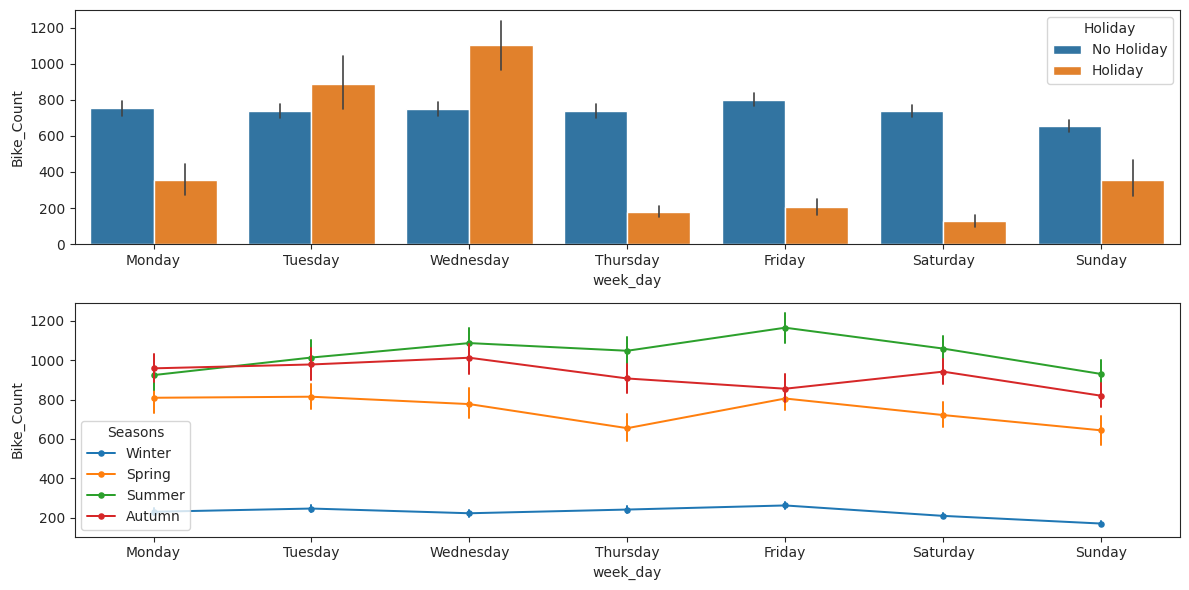

In [ ]:
# Week days
# Hourly average of bikes rented in days of the week

# The order of days of the week that we want to display in the plot
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set figure and subplots
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6), dpi=100)

# Plot
with plt.rc_context({'lines.linewidth': 0.8}): #line thickness
  sns.barplot(data=df_explore, x="week_day", y="Bike_Count", ax=axs[0], hue="Holiday", palette="tab10", order=order)
  sns.pointplot(data=df_explore, x="week_day", y="Bike_Count", ax=axs[1], hue="Seasons", palette="tab10", order=order)
plt.tight_layout()

From the plot above we can conclude that:
* It is hard to see any relationship between holidays and the days of the week, given the small number of holidays distributed across different seasons.
* Overall, there is a smaller number of average daily bike rentals during weekends vs during weekdays.
* The number of bikes rented is relatively stable over days of the week of same season.

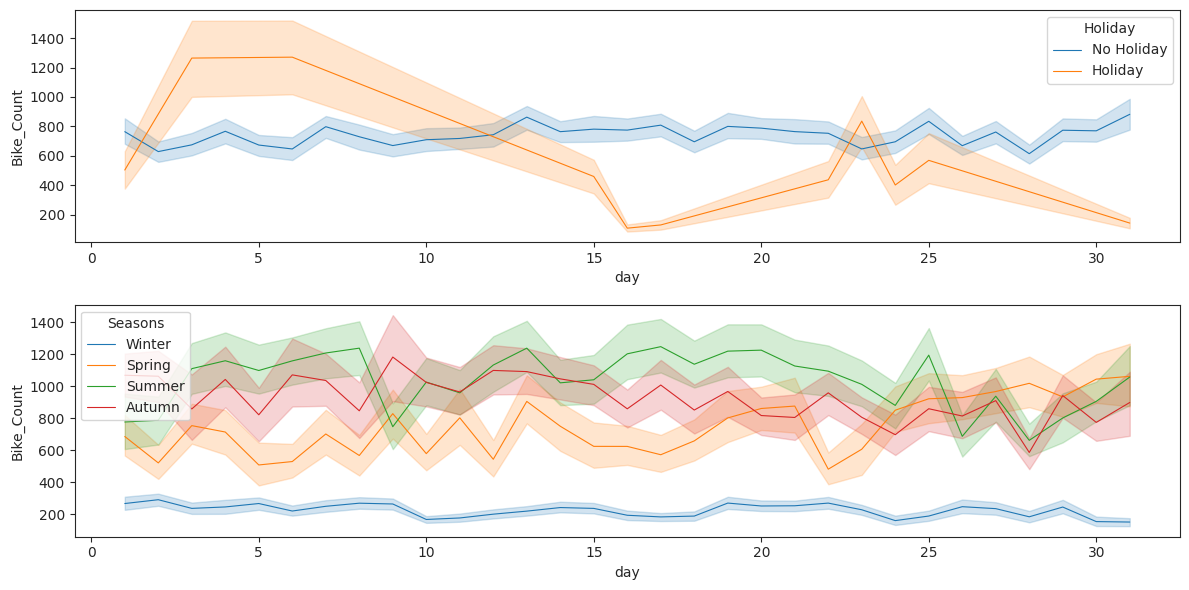

In [ ]:
# Monthly
# Hourly average of bikes rented in days of the month

# Set up figure and subplots
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6), dpi=100)

# Plot
with plt.rc_context({'lines.linewidth': 0.8}):
  sns.lineplot(data=df_explore, x="day", y="Bike_Count", ax=axs[0], hue="Holiday", palette="tab10")
  sns.lineplot(data=df_explore, x="day", y="Bike_Count", ax=axs[1], hue="Seasons", palette="tab10")
plt.tight_layout()

No clear dependency on the day of the month, and therefore this variable will likely not affect the modeling. It may be removed.

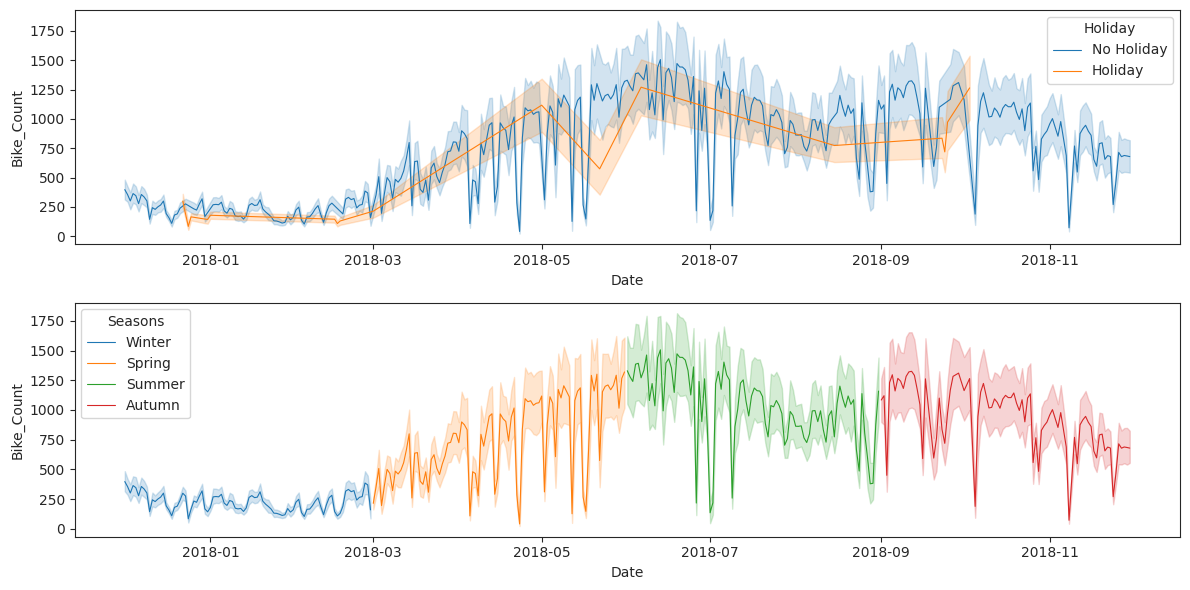

In [ ]:
# Yearly
# Hourly average of bikes rented in days of the year of data

# Set up figure and subplots
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6), dpi=100)

# Plot
with plt.rc_context({'lines.linewidth': 0.8}):
  ax0 = sns.lineplot(data=df_explore, x="Date", y="Bike_Count", ax=axs[0], hue="Holiday", palette="tab10")
  ax1 = sns.lineplot(data=df_explore, x="Date", y="Bike_Count", ax=axs[1], hue="Seasons", palette="tab10")

plt.tight_layout()

Note that:
* There are clear seasonal trends, but with strong fluctuations throughout the year, indicating need for refinement using the weather parameters (e.g., rain, temperature, humidity, etc.)
* The "Seasons" feature is just based on the month, and therefore, it will not be used (as already suggested previously), since the other weather parameters should cover the seasonal dependencies needed to explain the trends

**Monthly Dependencies**

Hourly average of bikes rented in the months of the year. This visualization should enable us to see the seasonal trends more clearly (less fluctuations due to daily weather patterns), given that the months do not have more than one season.

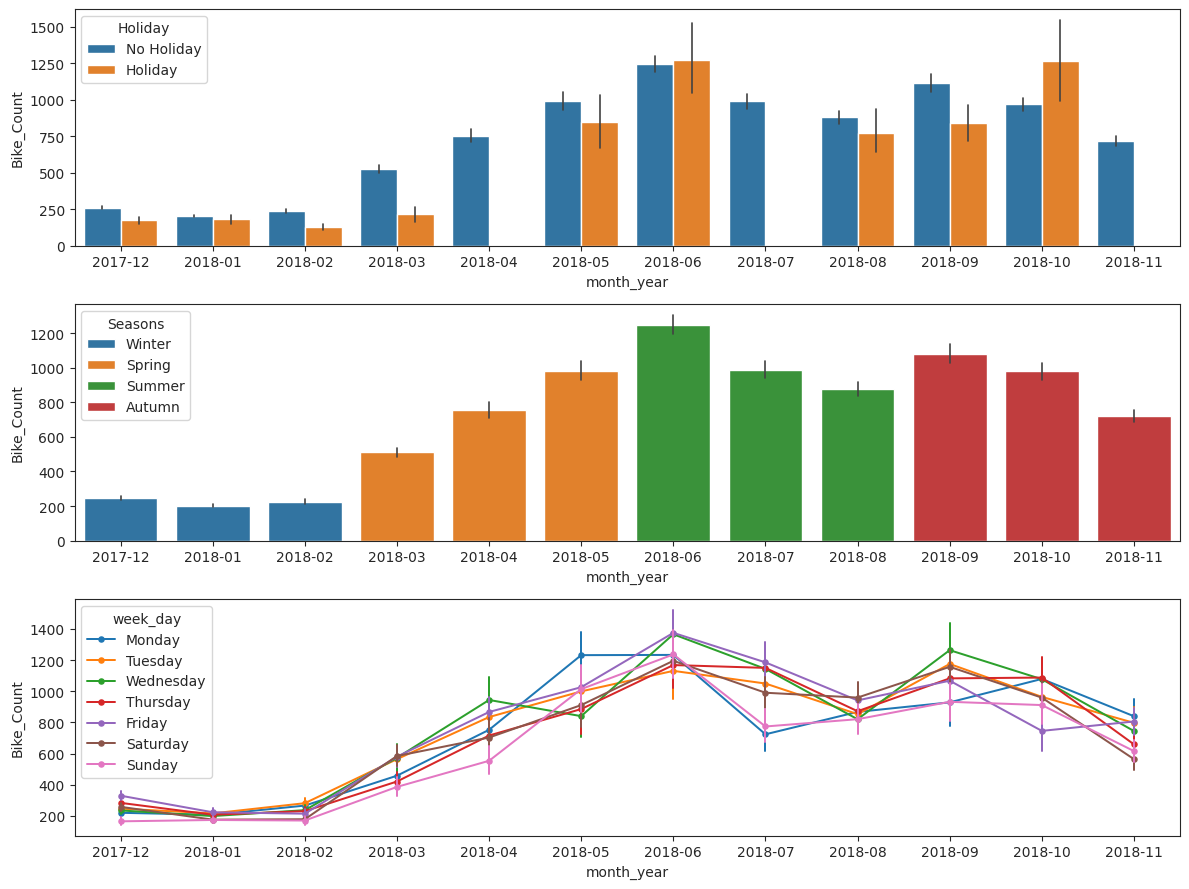

In [ ]:
# Hourly average of bikes rented per month - for the different categorical attributes

# The order of days of the week that we want to display in the plot
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set up figure and subplots
fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,9), dpi=100)

# Plot
with plt.rc_context({'lines.linewidth': 0.8}):
  ax0 = sns.barplot(data=df_explore, x="month_year", y="Bike_Count", ax=axs[0], hue="Holiday", palette="tab10")
  ax1 = sns.barplot(data=df_explore, x="month_year", y="Bike_Count", ax=axs[1], hue="Seasons", palette="tab10")
  ax2 = sns.pointplot(data=df_explore, x="month_year", y="Bike_Count", ax=axs[2], hue="week_day", palette="tab10", hue_order=order)

plt.tight_layout()

Note that the hourly average of 'Bike_Count' in each month per day of the week (bottom subplot) does not vary much. This likely indicates that the day of the week is more important for the hourly bike prediction rather than for the expected daily average.

###C. Numerical features: weather related measurements

The numerical features we have is this data set are provenient of weather-based measurements. We want to understand which additional preprocessing is needed for these features and which ones should be selected/changed (which ones are relevant).

Note that, although these are measurements, we have to keep in mind that if this was a true predictor for future use, we would need to take into account weather predictions to predict the demand for bikes. That would in further error in the predictions.

**Weather Analysis**

Understanding how some weather features can impact number of bikes rented.

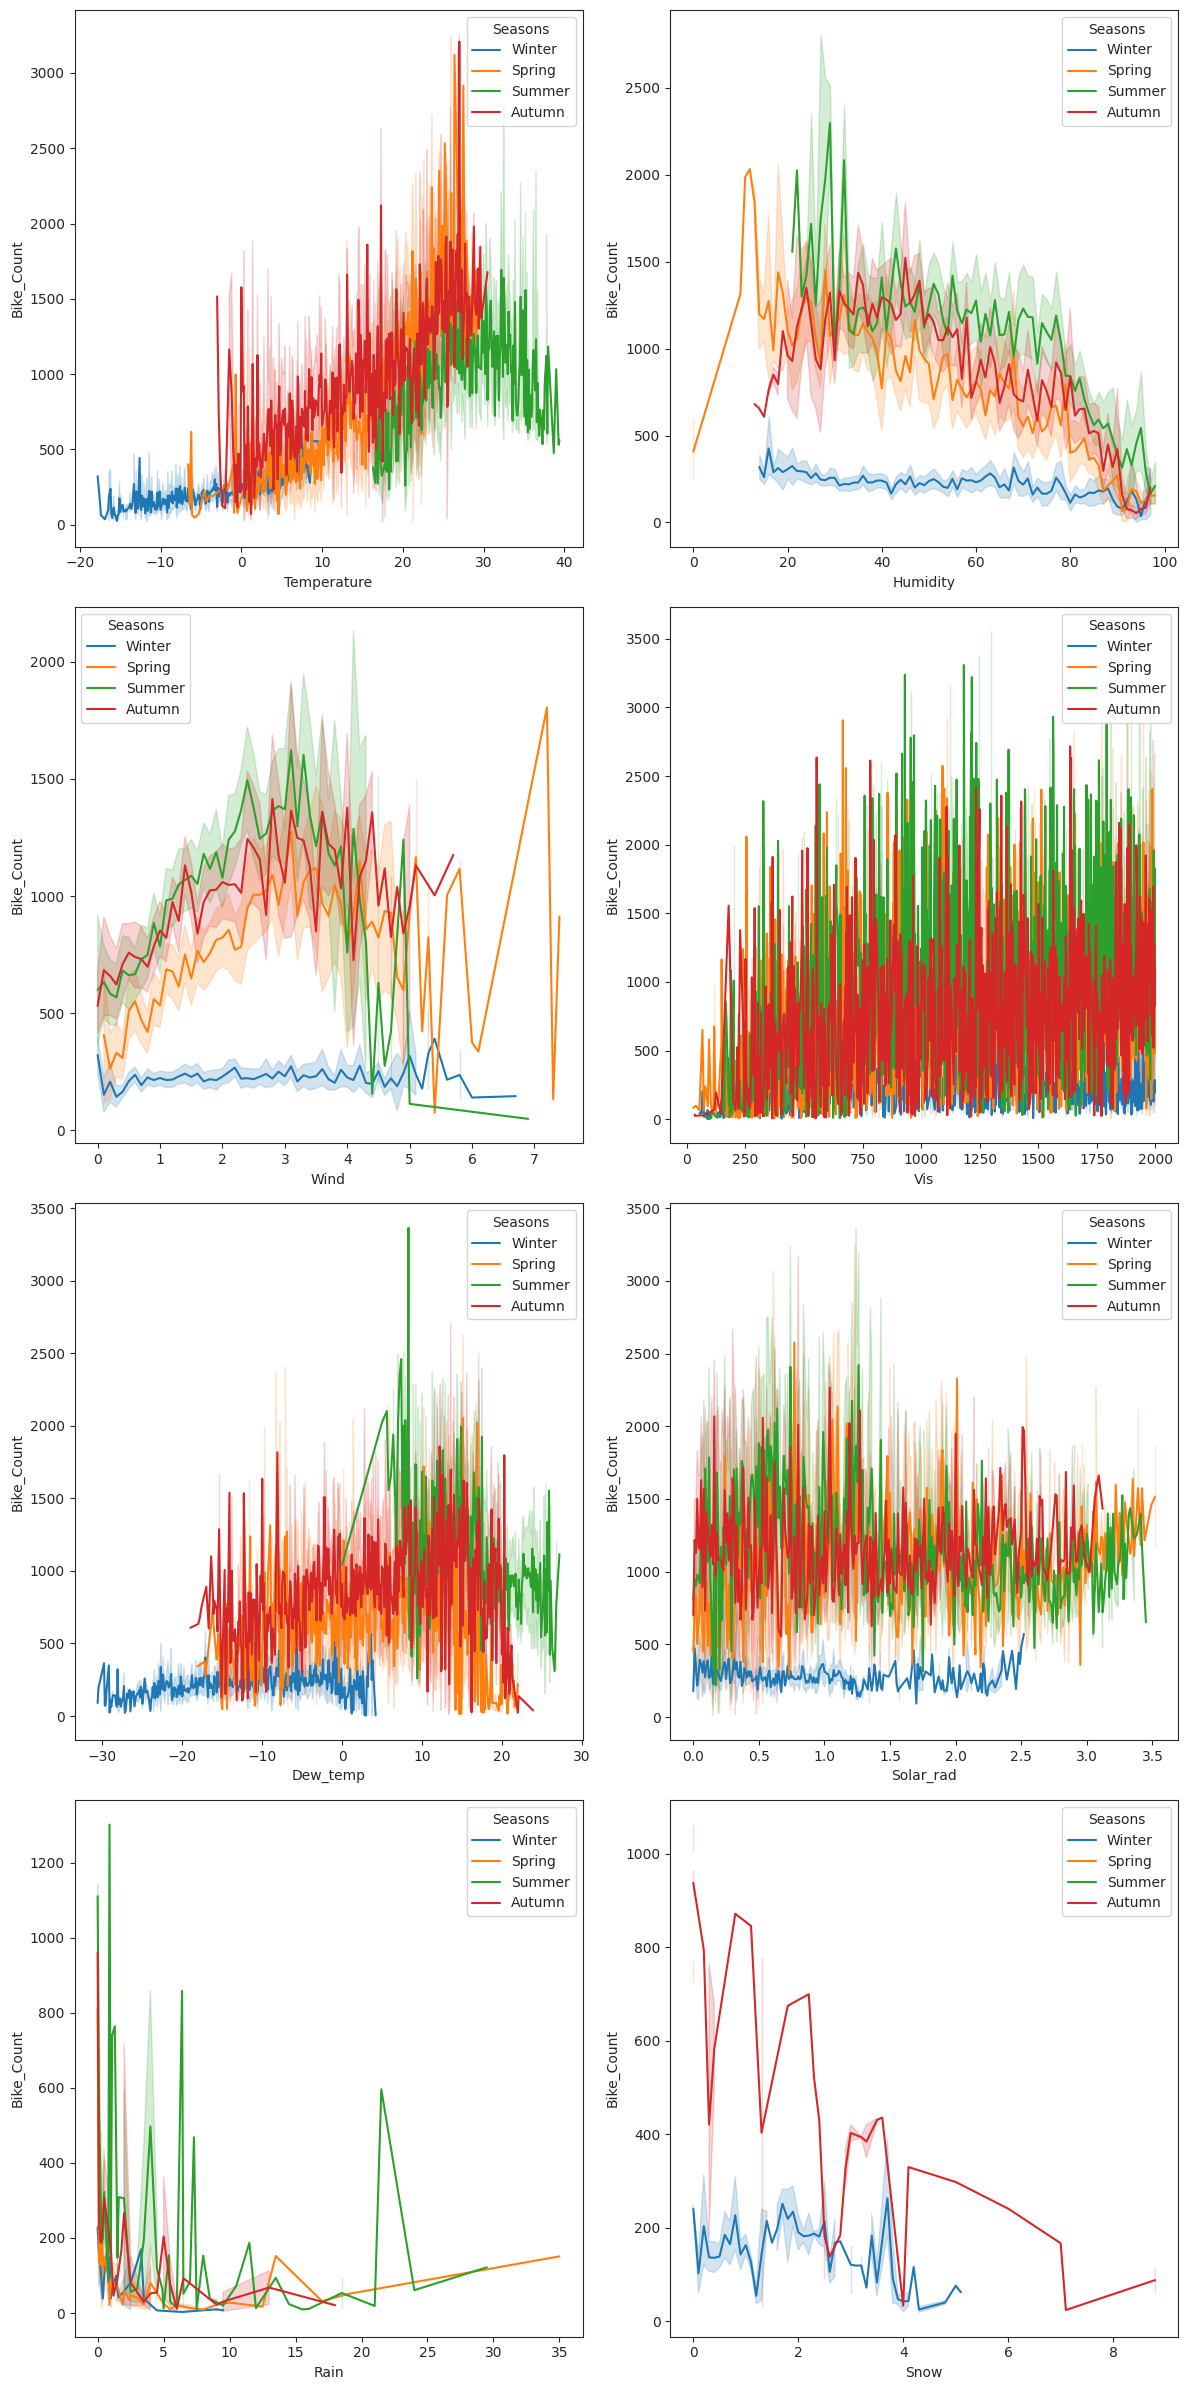

In [ ]:
# Comparing the dependency of bike demand on weather attributes.

# 8 numerical features (weather-based)
numerical_features = ['Temperature','Humidity','Wind','Vis','Dew_temp','Solar_rad','Rain','Snow']

# Set up figure and subplots
fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(12,24), dpi=100)

# Plot
for i, feat_element in enumerate(numerical_features):
  plt.subplot(4,2,i+1)
  sns.lineplot(data=df_explore, x=feat_element, y='Bike_Count', hue='Seasons', palette="tab10")

plt.tight_layout()

Now, let's compare the weather-based measurements to the number of rented bikes over the timeline of the data set.

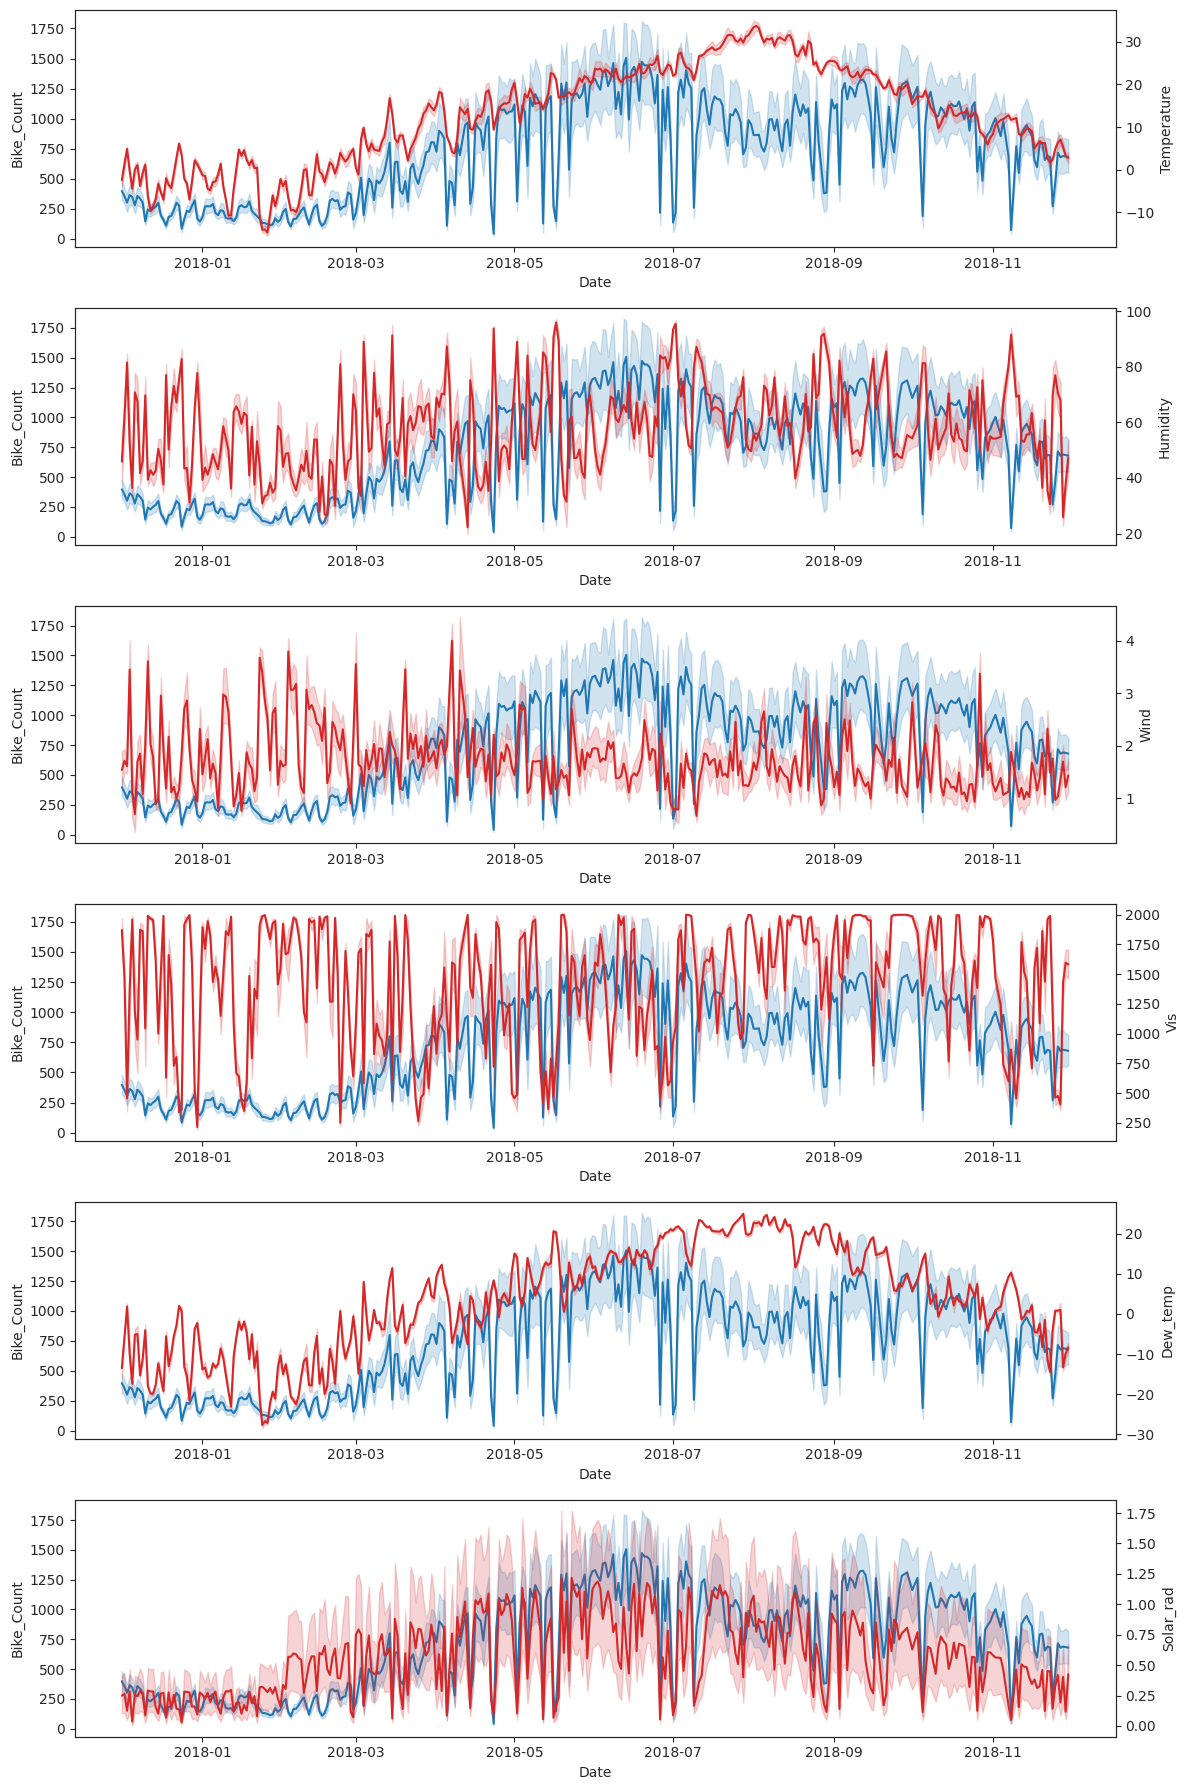

In [ ]:
# Looking at the comparison of bike rentals to the numerical attributes over time (except Rain & Snow - see more below)

# Numerical features in this figure
numerical_features = ['Temperature','Humidity','Wind','Vis','Dew_temp','Solar_rad']

# Set up figure
fig, axs = plt.subplots(nrows=len(numerical_features),ncols=1,figsize=(12,18), dpi=100)

# Loop over list of features and plot each subplot with two y-axis (one for the bikes rented per hour and one for the weather feature)
for i in range(len(numerical_features)):
  ax0 = sns.lineplot(data=df_explore, x='Date', y='Bike_Count', ax=axs[i], color="tab:blue")
  sns.lineplot(data=df_explore, x='Date', y=numerical_features[i], ax=ax0.axes.twinx(), color="tab:red")

plt.tight_layout()

Based on the comparisons above, we can see that:
* The distribution of bikes rented over time follows a similar macro trend to that of the **```Temperature```**  and the **```Dew point temperature```** (with some exceptions).
* Since the dew point temperature is based on a calculation of temperature and humidity, and as shown above, is *highly correlated to the temperature curve*, we can disconsider that attribute in the modeling (remove `Dew point temperature`).
* The Solar Radiation overarching trend seems to peak around the end of June (Northern Hemisphere summer solstice), which indicates that the daily average is driven mostly by the number of hours between sun rise and sun down. Daily variations are likely due to daily weather patterns (e.g., cloud coverage).
* Overall, we expect that in the dominand features above impacting the demand to be: **`Temperature`, `Humidity`, `Solar Radiation`**.

Now, let's investigate the `Rain` and `Snow` dependency.
Rain and snow indicators might impact demand for entire days instead of only at the hour of measurement. For example: people might not rent bikes based on weather forecasts if it indicates that it will rain/snow, or snow/rain accumulation might be large from previous hours and impact future rentals. This could be an interesting thing to explore for models with only predicted weather features instead of data, for example.

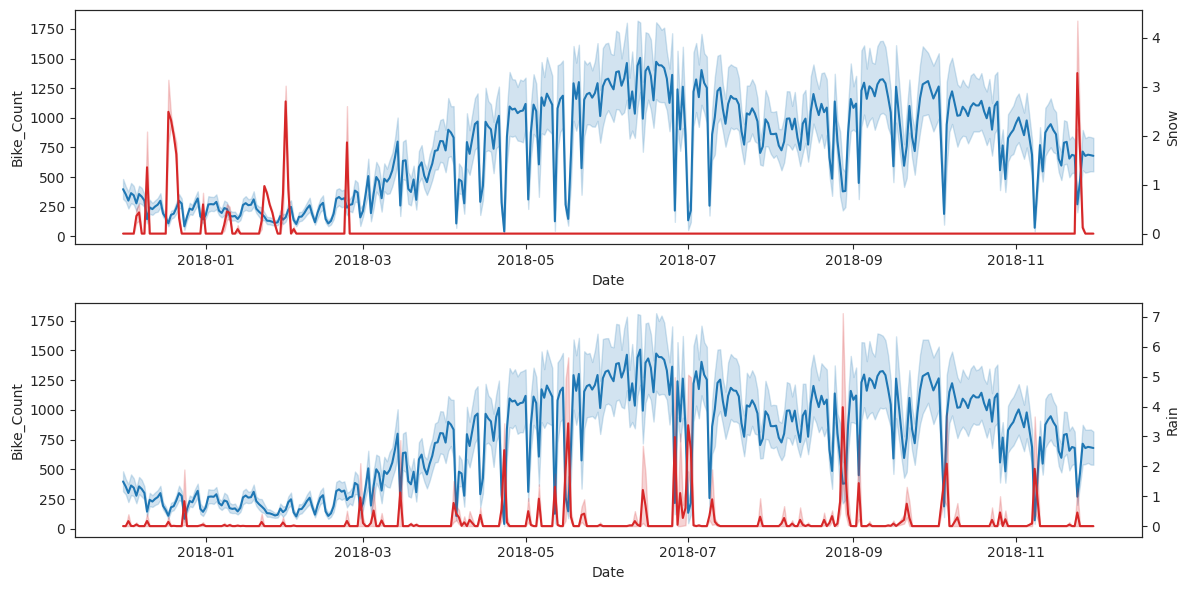

In [ ]:
# Rain and Snow
# Looking at the comparison of bike rentals to the Rain and Snow attributes over time

# Set up figure and subplots
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6), dpi=100)

# Plot two y-axis
ax0 = sns.lineplot(data=df_explore, x='Date', y='Bike_Count', ax=axs[0], color="tab:blue")
ax1 = sns.lineplot(data=df_explore, x='Date', y='Bike_Count', ax=axs[1], color="tab:blue")
sns.lineplot(data=df_explore, x='Date', y='Snow', ax=ax0.axes.twinx(), color="tab:red")
sns.lineplot(data=df_explore, x='Date', y='Rain', ax=ax1.axes.twinx(), color="tab:red")

plt.tight_layout()

As we can see above, even small amounts of rain and snow can impact the number of bikes rented (not a proportional response), possibly due to what is predicted for that day.

### Take aways from the exploratory data analysis

**Conclusion of exploratory data analysis:**

**1. Observations**
* There is a cluster of non-functioning days close to day 300 that seem to provide a small skew to the distribution, requiring further evaluation of possible impact in the training later.
* Holidays constitute only ~5% of the data, and therefore we should ensure we have enough samples in the training set to correctly model the demand during Holidays.
* There are peaks of rented bikes at hours 8h and 18h, likely due to transportation to/from work (rush hour), as they are NOT observed during Holidays and weekends.
* There is a large suppression on the average number of bikes rented during the Winter across the entire day (less pronounced features in the distribution).
* The hourly distribution of bikes rented during Holidays is more similar to the weekend ones, even though holidays are well distributed through days of the week.
* Given the intrinsic changes over time on weather caused by seasons, the attribute 'Seasons' does not seem necessary - in fact, other time variables will provide a more refined dependency to the bike demand.
* Since the distributions of the weekdays are closely matched, we will add a new categorical feature ('isWeekday') to check if the day is a weekday (1) or weekend (0) instead of applying label encoding to the 'week_day' variable and increasing the dimensionality substantially.
* The distribution of bikes rented over time follows a similar macro trend to that of the temperature and the dew point temperature (which is closely related to temperature and humidity, and therefore will be removed).
* The Solar Radiation overarching trend seems to peak around the end of June (Northern Hemisphere summer solstice), which indicates that the daily average is driven mostly by the number of hours between sun rise and sun down. Daily variations likely due to daily weather patterns (e.g., cloud coverage).

**2. Updated Hypotheses**

* Given that we have only one year of data, it is unclear from the dataset alone if there is really a positive trend in the data due simply to the overall market size growth (https://www.statista.com/statistics/868126/global-bikesharing-market-size/).
* There is a clear seasonal dependency on the demand for bikes due to changes in seasonal patterns, including a correlation to temperature (demand decreases with too high or too low temperatures), with non-linear relationships to time (modulates over the year and day) and weather features.
* There are weather based daily and hourly fluctuations on the number of bikes required due to fluctuations on weather (e.g., rain, snow, temperature) in addition to the seasonal trends, e.g., heavy rain, too high temeperatures, too high humidity, heavy snow accumulation, strong winds, etc.
* There is a hour of the day dependency in the demand of bikes, e.g., higher demand during rush hour during weekdays and non-holidays


## Feature engineering

Now that we have a better context of the changes necessary to model the data appropriately, we will apply these changes to the `dataset_clean` dataframe created under the "Initial data preparation" section.

In [ ]:
# Add refined time series features to data set

# Make working copy of clean dataset
df_processing = dataset_clean.copy()

# Get month number. Note that, based on the exploratory data analysis, the day of the month is not important.
# Since we have only one year of data (2017-2018), the year will also not matter for our example.
df_processing['month'] = dataset_clean['Date'].dt.month

# Get day of the week (categorical)
df_processing['week_day'] = dataset_clean['Date'].dt.day_name()

# Get order of days (starts in first day recorded - 2017/12/01)
df_processing['date_order'] = pd.to_datetime(dataset_clean['Date']).apply(lambda Date: Date.toordinal())
df_processing['date_order'] = df_processing['date_order']-df_processing['date_order'].min()

# Remove 'Date' columns, since we now have all the information we need broken down
df_processing = df_processing.drop('Date', axis=1)

# Check updated dataframe
print("Number of functioning days: ", df_processing["date_order"].nunique())
df_processing.head()


Number of functioning days:  353


Bike_Count  Hour  Temperature  Humidity  Wind   Vis  Dew_temp  Solar_rad  \
0         254     0         -5.2        37   2.2  2000     -17.6        0.0   
1         204     1         -5.5        38   0.8  2000     -17.6        0.0   
2         173     2         -6.0        39   1.0  2000     -17.7        0.0   
3         107     3         -6.2        40   0.9  2000     -17.6        0.0   
4          78     4         -6.0        36   2.3  2000     -18.6        0.0   

   Rain  Snow Seasons     Holiday  month week_day  date_order  
0   0.0   0.0  Winter  No Holiday     12   Friday           0  
1   0.0   0.0  Winter  No Holiday     12   Friday           0  
2   0.0   0.0  Winter  No Holiday     12   Friday           0  
3   0.0   0.0  Winter  No Holiday     12   Friday           0  
4   0.0   0.0  Winter  No Holiday     12   Friday           0

Based on the exploratory data analysis, we can see that some modifications of features will be necessary, such as:

* Remove the `Dew_temp`, given it's correlation to temperature and humidity
* Addition of the `isWeekday` variable - dependent on the day of the week
* Encoding of `Holiday`

Note that `Seasons` and `week_day` will not be used in the modeling, and therefore will not be encoded. They will be kept in the dataframe for now to alow for easy checks regarding the distributions of the train/test sets later on, but will not be used any further.


In [ ]:
# Based on Exploratory Data Analysis, let's remove 'Dew_temp' (dependent on 'Temperature'and 'Humidity')
df_processing = df_processing.drop('Dew_temp', axis=1)

Let's add the `isWeekday` attribute to differentiate between weekdays (1) and weekends (0) and the `isHoliday` attribute to tag holidays (1) vs. non-holidays (0), since the hourly distribution of bike rentals varies between them.

In [ ]:
mapping_dicWeekday={'Monday':1,'Tuesday':1,'Wednesday':1,'Thursday':1,'Friday':1,'Saturday':0,'Sunday':0}
df_processing['isWeekday'] = df_processing['week_day'].map(mapping_dicWeekday)

In [ ]:
df_processing['isHoliday']=df_processing['Holiday'].map({'No Holiday':0,'Holiday':1})
df_processing = df_processing.drop('Holiday', axis=1)

In [ ]:
df_processing.head(1)

Bike_Count  Hour  Temperature  Humidity  Wind   Vis  Solar_rad  Rain  Snow  \
0         254     0         -5.2        37   2.2  2000        0.0   0.0   0.0   

  Seasons  month week_day  date_order  isWeekday  isHoliday  
0  Winter     12   Friday           0          1          0

Although we have most of everything that we will need now, let's reflect upon the seasonality of the data set.

Since this time series seems to have a strong dependency on weather parameters, we need to keep in mind that the current time variables will likely not support a linear model. We would likely need to provide a modulating component, specially for non tree-based estimators.

Therefore, let's look at our encoding options for the time variables.

* `month`:
  * One-Hot Encoding (dummy variables): creating 11 (12 minus 1) binary attributes to allow for specific fitting per month.
  * Sine/Cosine transformation: breaking down each month in two columns, sin and cosine, based on a transformation of period 12 months.
* `date_order`: Similar to 'month', but with period of 365 days. Not helpful to use One-Hot encoding due to large number of columns that would be added.
* `Hour`: Similar to 'month', but with period of 24hs.


We will perform both the One-Hot encoding and the sine/cosine cyclic encoding to the month and hour variables, and then compare the results for different types os encoding to analyze if there is a significant improvement to models NOT based on tree estimators.

Month

In [ ]:
# Cyclic encoding
period = 12
df_processing['month_sin'] = np.sin(2 * np.pi * df_processing['month']/period)
df_processing['month_cos'] = np.cos(2 * np.pi * df_processing['month']/period)

In [ ]:
# One-hot encoding
df_processing['month_orig'] = df_processing['month'] # Keeping original
df_processing = pd.get_dummies(df_processing,columns=['month'],drop_first=True, dtype=int)

Date

In [ ]:
# Cyclic encoding
period = 365
df_processing['date_sin'] = np.sin(2 * np.pi * df_processing['date_order']/period)
df_processing['date_cos'] = np.cos(2 * np.pi * df_processing['date_order']/period)

Hour

In [ ]:
# Cyclic encoding
period = 24
df_processing['hour_sin'] = np.sin(2 * np.pi * df_processing['Hour']/period)
df_processing['hour_cos'] = np.cos(2 * np.pi * df_processing['Hour']/period)

In [ ]:
# One-hot encoding
df_processing['hour_orig'] = df_processing['Hour'] # Keeping original
df_processing = pd.get_dummies(df_processing,columns=['Hour'],drop_first=True, dtype=int)

In [ ]:
df_processing.shape
df_processing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8465 entries, 0 to 8759
Data columns (total 55 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Bike_Count   8465 non-null   int64  
 1   Temperature  8465 non-null   float64
 2   Humidity     8465 non-null   int64  
 3   Wind         8465 non-null   float64
 4   Vis          8465 non-null   int64  
 5   Solar_rad    8465 non-null   float64
 6   Rain         8465 non-null   float64
 7   Snow         8465 non-null   float64
 8   Seasons      8465 non-null   object 
 9   week_day     8465 non-null   object 
 10  date_order   8465 non-null   int64  
 11  isWeekday    8465 non-null   int64  
 12  isHoliday    8465 non-null   int64  
 13  month_sin    8465 non-null   float64
 14  month_cos    8465 non-null   float64
 15  month_orig   8465 non-null   int32  
 16  month_2      8465 non-null   int64  
 17  month_3      8465 non-null   int64  
 18  month_4      8465 non-null   int64  
 19  month_5    

## Training/Test Data Separation

Now that we have all features that will be needed at a first moment, let's make a new working copy of the data to symplify the tracking.

In [ ]:
df_processed = df_processing.copy()

print(df_processed.columns)

Index(['Bike_Count', 'Temperature', 'Humidity', 'Wind', 'Vis', 'Solar_rad',
       'Rain', 'Snow', 'Seasons', 'week_day', 'date_order', 'isWeekday',
       'isHoliday', 'month_sin', 'month_cos', 'month_orig', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'date_sin', 'date_cos',
       'hour_sin', 'hour_cos', 'hour_orig', 'Hour_1', 'Hour_2', 'Hour_3',
       'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10',
       'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16',
       'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22',
       'Hour_23'],
      dtype='object')


Since we have redundant time features right now (e.g., month, month sin/cos, month one-hot encoding columns, etc.), we will build three different sets of training and test data and compare the feature selection and models performance for them. Before creating these versions of the same training and test sets, we will:
* create the **master training and test sets**, so that all versions have the same samples of data
* ensure they generalize well with Adversarial Validation
* check with visualization for some of the more concerning features (e.g., Holidays and their low statistics, weekdays vs. weekends)

Once those steps are concluded, we will follow with the creation of the different versions.


Before we start dividing the data set, we should reflect upon the nature of this problem. We currently have hourly entries for one year of data. Ideally we would have more than a year of data, being able to leave the test sample to latter times in the series (e.g., train the data with one year and test with the following). However, that is not possible, due to this time constraint on the measurements.

In order to correct train and test our model, we will divide our data selecting 80% for training and 20% for test, but we will group the data by days. That means that all samples (24 samples for the 24 hours) of a day will be within one of the sets (train / test). We will not have samples for the same day in different sets. This will allow for the model to not be influenced by information of the rest of other samples from the same day when trying to fit.

Note that we will use Scikit-learn's `GroupShuffleSlip` to divide the data set in this way.

In [ ]:
# First, divide data between training and test sets (holdout), creating the master sets

# Set up X and Y arrays
array_master = df_processed.values
X_master = array_master[:,1:] # time + weather-based attributes
y_master = array_master[:,0] # target - Bike_Count

# Divide between train (80%) and test (20%)
testFraction = 0.2

# Using GroupShuffleSplit to divide the data between train and test
# Set up split
n_folds = 1 # one group of training and one of testing
gss_train_test = GroupShuffleSplit(n_splits=n_folds, random_state=7, test_size=testFraction)

# Get group of days (days since start of data set) in the data set - which group (day) each entry is part of
groups_day = df_processed['date_order'].values

# Split the data and get the indices of train and test samples
[(train_master_index, test_master_index)] = gss_train_test.split(X_master, y_master, groups_day)

# Create dataframes for train and test subsets based on indices above
df_train = df_processed.iloc[train_master_index]
df_test = df_processed.iloc[test_master_index]

print(df_train.shape)
print(df_test.shape)

(6761, 55)
(1704, 55)


In [ ]:
df_train.columns.values

array(['Bike_Count', 'Temperature', 'Humidity', 'Wind', 'Vis',
       'Solar_rad', 'Rain', 'Snow', 'Seasons', 'week_day', 'date_order',
       'isWeekday', 'isHoliday', 'month_sin', 'month_cos', 'month_orig',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'date_sin', 'date_cos', 'hour_sin', 'hour_cos', 'hour_orig',
       'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
       'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
       'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
       'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23'],
      dtype=object)

There is a total of 52 attributes that are being considered right now (55 columns if we consider the target - `Bike_Count` - and the two attributes kept for reference and visualization - `Seasons` & `week_day`) . Let's now check the generalization of the training set with Adversarial Validation and additional visualization.

### Checking generalization of training set

#### Adversarial Validation

In [ ]:
# Adversarial Validation - checking if training and test sets are, in this case, well distributed across all variables

# Creating the tag (target of the classification to be done)
df_train['adversarial_tag'] = [0]*df_train['hour_orig'].size #train = 0
df_test['adversarial_tag'] = [1]*df_test['hour_orig'].size #test = 1

# Concat the two data frames
df_adversarial = pd.concat([df_train,df_test])

# Drop the variables that will not be used in modeling
df_adversarial = df_adversarial.drop(['Seasons','week_day'], axis=1)

# Dividing Adversarial Validation X and y
adversarial_array = df_adversarial.values
X_adversarial = adversarial_array[:,1:-1] # Removing column 0 (Bike_Count)
y_adversarial = adversarial_array[:,-1] # adversarial_tag as target of this validation

# Checking sizes
print(X_adversarial.shape)
print(y_adversarial.shape)

(8465, 52)
(8465,)


In [ ]:
# Creating the model to check connection between training and testing set
model_AV = RandomForestClassifier()
cv_preds = cross_val_predict(model_AV, X_adversarial, y_adversarial, cv=5, n_jobs=-1, method='predict_proba')

# Checking ROC accuracy
print(roc_auc_score(y_true=y_adversarial, y_score=cv_preds[:,1]))

0.49407507883171436


As we can see, the ROC AUC metric is ~50%, which means that the prediction is close to a random guess. This validates our expectations of well distributed training and test sets.

In [ ]:
# Removing the adversarial tag column
df_train = df_train.drop('adversarial_tag', axis=1)
df_test = df_test.drop('adversarial_tag', axis=1)

#### Visualization

###### Overall ######
All data: Mean = 178.38, Std = 104.68
Training data: Mean = 175.75, Std = 103.34
Test data: Mean = 188.86, Std = 109.25 

###### isHoliday = 1 ######
All data: Mean = 142.00, Std = 108.10
Training data: Mean = 127.42, Std = 104.96
Share of holiday entries in training data: 70.59%
Test data: Mean = 177.00, Std = 107.93
Share of holiday entries in test data: 29.41% 



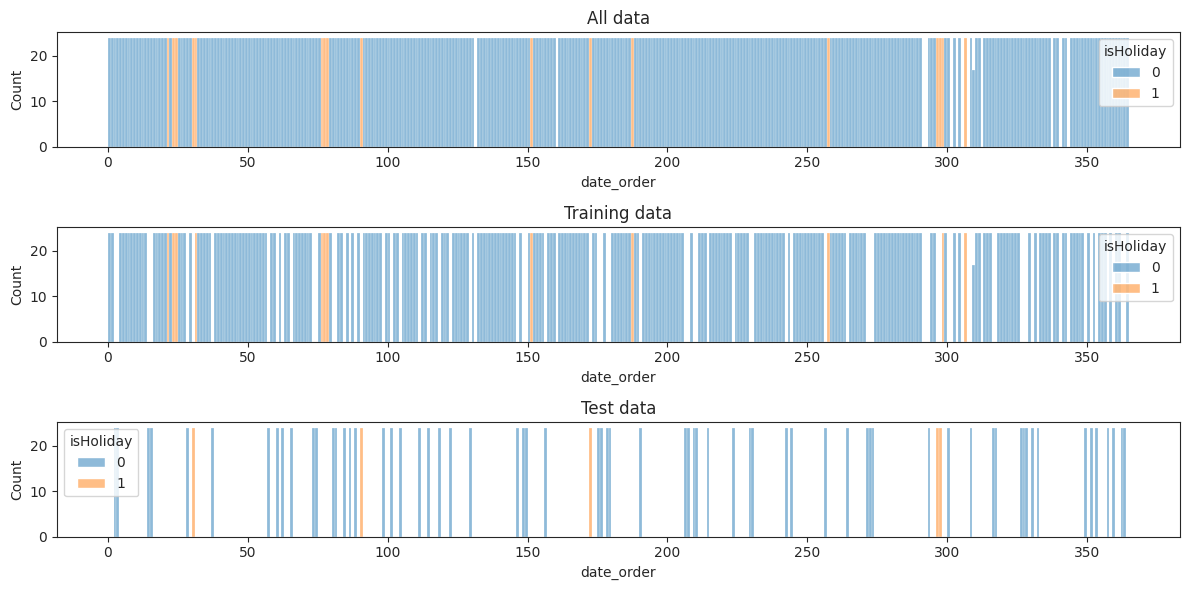

In [ ]:
# Check the distribution of the training and test sets over time (days)

#Holiday
feature = "isHoliday"
time = 'date_order'

bin_range = (df_processed[time].min(),df_processed[time].max()+1)

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,6), dpi=100)

with plt.rc_context({'lines.linewidth': 0.8}):
  #All data
  sns.histplot(data=df_processed, x=time, ax=axs[0], binwidth=1, binrange=bin_range, hue=feature, palette="tab10")
  axs[0].set_title("All data")
  #Training
  sns.histplot(data=df_train, x=time, ax=axs[1], binwidth=1, binrange=bin_range, hue=feature, palette="tab10")
  axs[1].set_title("Training data")
  #Test
  sns.histplot(data=df_test, x=time, ax=axs[2], binwidth=1, binrange=bin_range, hue=feature, palette="tab10")
  axs[2].set_title("Test data")

plt.tight_layout()

print("###### Overall ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[time].mean(), df_processed[time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[time].mean(), df_train[time].std()))
print("Test data: Mean = %0.2f, Std = %0.2f \n" % (df_test[time].mean(), df_test[time].std()))

print("###### isHoliday = 1 ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==1][time].mean(), df_processed[df_processed[feature]==1][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==1][time].mean(), df_train[df_train[feature]==1][time].std()))
print("Share of holiday entries in training data: %0.2f%%" % (df_train[df_train[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==1][time].mean(), df_test[df_test[feature]==1][time].std()))
print("Share of holiday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))


We can see that about 30% of holidays were selected to test, instead of 20%.

###### Overall ######
All data: Mean = 178.38, Std = 104.68
Training data: Mean = 175.75, Std = 103.34 

###### is Weekday ######
All data: Mean = 179.00, Std = 104.91
Training data: Mean = 174.44, Std = 104.77
Share of weekday entries in training: 79.28%
Test data: Mean = 196.44, Std = 103.62
Share of weekday entries in test data: 20.72% 

###### is not Weekday ######
All data: Mean = 176.88, Std = 104.13
Training data: Mean = 178.89, Std = 99.75
Share of not weekday entries in training: 81.32%
Test data: Mean = 168.11, Std = 121.07
Share of not weekday entries in test data: 18.68% 



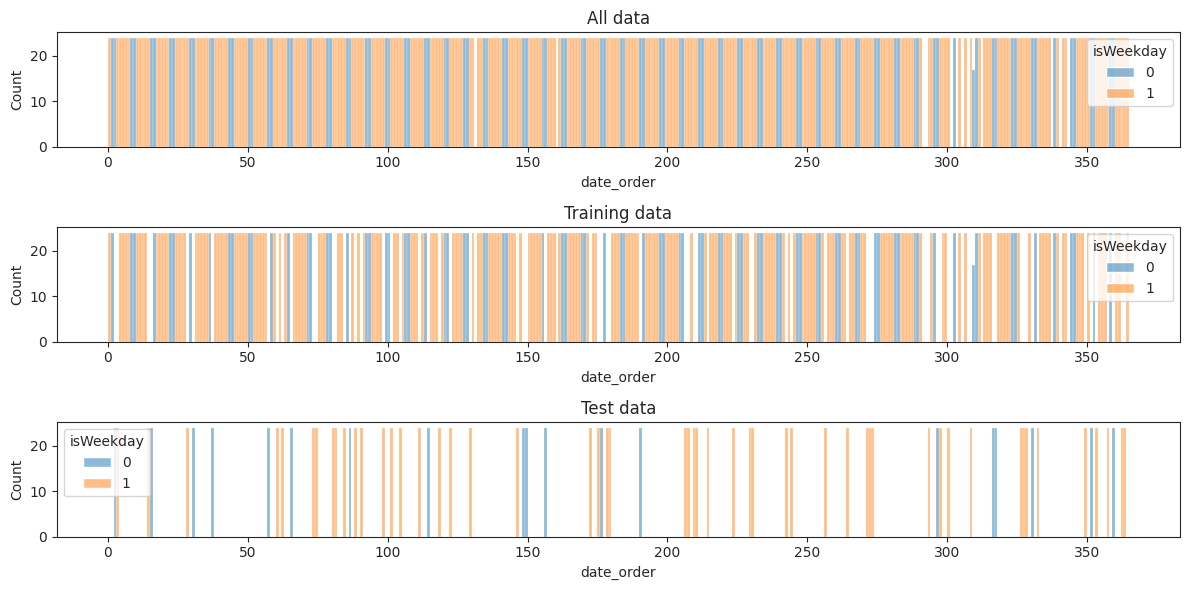

In [ ]:
# Check the distribution of the training and test sets over time (days)

# Weekday
feature = "isWeekday"
time = 'date_order'

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,6), dpi=100)
with plt.rc_context({'lines.linewidth': 0.8}):
  # All data
  ax0 = sns.histplot(data=df_processed, x=time, ax=axs[0], binwidth=1, binrange=(df_processed[time].min(),df_processed[time].max()+1), hue=feature, palette="tab10")
  ax0.set_title("All data")
  # Training
  ax1 = sns.histplot(data=df_train, x=time, ax=axs[1], binwidth=1, binrange=(df_processed[time].min(),df_processed[time].max()+1), hue=feature, palette="tab10")
  ax1.set_title("Training data")
  # Test
  ax2 = sns.histplot(data=df_test, x=time, ax=axs[2], binwidth=1, binrange=(df_processed[time].min(),df_processed[time].max()+1), hue=feature, palette="tab10")
  ax2.set_title("Test data")

plt.tight_layout()

print("###### Overall ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[time].mean(), df_processed[time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f \n" % (df_train[time].mean(), df_train[time].std()))

print("###### is Weekday ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==1][time].mean(), df_processed[df_processed[feature]==1][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==1][time].mean(), df_train[df_train[feature]==1][time].std()))
print("Share of weekday entries in training: %0.2f%%" % (df_train[df_train[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==1][time].mean(), df_test[df_test[feature]==1][time].std()))
print("Share of weekday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))

print("###### is not Weekday ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==0][time].mean(), df_processed[df_processed[feature]==0][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==0][time].mean(), df_train[df_train[feature]==0][time].std()))
print("Share of not weekday entries in training: %0.2f%%" % (df_train[df_train[feature]==0][time].count()/df_processed[df_processed[feature]==0][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==0][time].mean(), df_test[df_test[feature]==0][time].std()))
print("Share of not weekday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==0][time].count()/df_processed[df_processed[feature]==0][time].count()*100))


###### Overall ######
All data: Mean = 11.51, Std = 6.92
Training data: Mean = 11.51, Std = 6.92
Test data: Mean = 11.50, Std = 6.92 

###### isHoliday = 1 ######
All data: Mean = 11.50, Std = 6.93
Training data: Mean = 11.50, Std = 6.93
Share of holiday entries in training data: 70.59%
Test data: Mean = 11.50, Std = 6.95
Share of holiday entries in test data: 29.41% 



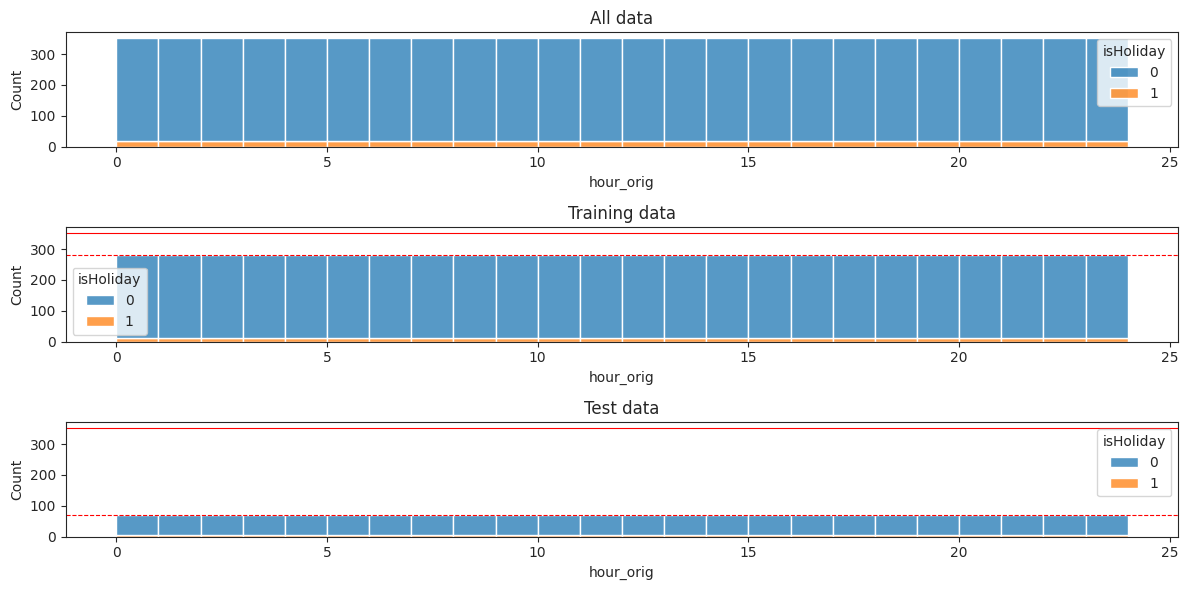

In [ ]:
# Check the distribution of the training and test sets over time (hours)

#Holiday
feature = "isHoliday"
time = 'hour_orig'

bin_range = (df_processed[time].min(),df_processed[time].max()+1)

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,6), dpi=100)

with plt.rc_context({'lines.linewidth': 0.8}):
  #All data
  sns.histplot(data=df_processed, x=time, ax=axs[0], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  axs[0].set_title("All data")
  #Training
  sns.histplot(data=df_train, x=time, ax=axs[1], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  axs[1].set_title("Training data")
  axs[1].axhline(y=353, color='r') # line at maximum count number
  axs[1].axhline(y=353*0.8, color='r', linestyle="--") # expected training value: 80%
  #Test
  sns.histplot(data=df_test, x=time, ax=axs[2], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  axs[2].set_title("Test data")
  axs[2].axhline(y=353, color='r') # line at maximum count number
  axs[2].axhline(y=353*0.2, color='r', linestyle="--") # expected training value: 20%

plt.tight_layout()

print("###### Overall ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[time].mean(), df_processed[time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[time].mean(), df_train[time].std()))
print("Test data: Mean = %0.2f, Std = %0.2f \n" % (df_test[time].mean(), df_test[time].std()))

print("###### isHoliday = 1 ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==1][time].mean(), df_processed[df_processed[feature]==1][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==1][time].mean(), df_train[df_train[feature]==1][time].std()))
print("Share of holiday entries in training data: %0.2f%%" % (df_train[df_train[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==1][time].mean(), df_test[df_test[feature]==1][time].std()))
print("Share of holiday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))


###### Overall ######
All data: Mean = 11.51, Std = 6.92
Training data: Mean = 11.51, Std = 6.92 

###### is Weekday ######
All data: Mean = 11.50, Std = 6.92
Training data: Mean = 11.50, Std = 6.92
Share of weekday entries in training: 79.28%
Test data: Mean = 11.50, Std = 6.92
Share of weekday entries in test data: 20.72% 

###### is not Weekday ######
All data: Mean = 11.52, Std = 6.92
Training data: Mean = 11.53, Std = 6.92
Share of not weekday entries in training: 81.32%
Test data: Mean = 11.50, Std = 6.93
Share of not weekday entries in test data: 18.68% 



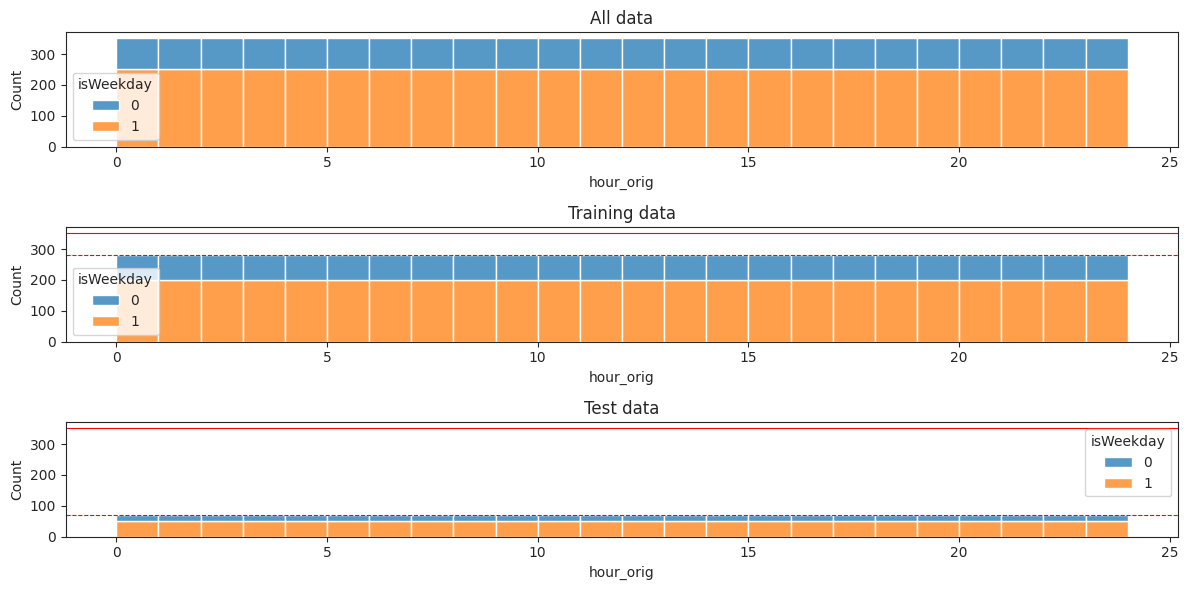

In [ ]:
# Check the distribution of the training and test sets over time (Hours)

# Weekday
feature = "isWeekday"
time = 'hour_orig'

bin_range = (df_processed[time].min(),df_processed[time].max()+1)

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,6), dpi=100)
with plt.rc_context({'lines.linewidth': 0.8}):
  ax0 = sns.histplot(data=df_processed, x=time, ax=axs[0], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  ax0.set_title("All data")
  ax1 = sns.histplot(data=df_train, x=time, ax=axs[1], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  ax1.set_title("Training data")
  ax1.axhline(y=353, color='r') # line at maximum count number
  ax1.axhline(y=353*0.8, color='r', linestyle="--") # expected training value: 80%
  ax2 = sns.histplot(data=df_test, x=time, ax=axs[2], binwidth=1, binrange=bin_range, hue=feature, palette="tab10", multiple="stack")
  ax2.set_title("Test data")
  ax2.axhline(y=353, color='r') # line at maximum count number
  ax2.axhline(y=353*0.2, color='r', linestyle="--") # expected training value: 20%

plt.tight_layout()

print("###### Overall ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[time].mean(), df_processed[time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f \n" % (df_train[time].mean(), df_train[time].std()))

print("###### is Weekday ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==1][time].mean(), df_processed[df_processed[feature]==1][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==1][time].mean(), df_train[df_train[feature]==1][time].std()))
print("Share of weekday entries in training: %0.2f%%" % (df_train[df_train[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==1][time].mean(), df_test[df_test[feature]==1][time].std()))
print("Share of weekday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==1][time].count()/df_processed[df_processed[feature]==1][time].count()*100))

print("###### is not Weekday ######")
print("All data: Mean = %0.2f, Std = %0.2f" % (df_processed[df_processed[feature]==0][time].mean(), df_processed[df_processed[feature]==0][time].std()))
print("Training data: Mean = %0.2f, Std = %0.2f" % (df_train[df_train[feature]==0][time].mean(), df_train[df_train[feature]==0][time].std()))
print("Share of not weekday entries in training: %0.2f%%" % (df_train[df_train[feature]==0][time].count()/df_processed[df_processed[feature]==0][time].count()*100))
print("Test data: Mean = %0.2f, Std = %0.2f" % (df_test[df_test[feature]==0][time].mean(), df_test[df_test[feature]==0][time].std()))
print("Share of not weekday entries in test data: %0.2f%% \n" % (df_test[df_test[feature]==0][time].count()/df_processed[df_processed[feature]==0][time].count()*100))


## Comparing versions of time atributes

We created a master version of the training and test data sets and performed the adversarial validation. Now, we want to create three versions of these sets. Let's name them:
* V1: for the original time attributes extracted from the 'Date' information in the raw data set ('hour_orig', 'month_orig', 'date_order'), in addition to other features (weather plus categorical attributes)
* V2: for the cyclic time attributes ('month_sin/cos', 'date_sin/cos', 'hour_sin/cos'), in addition to other features (weather plus categorical attributes)
* V3: for the time attributes from one-hot encoding (for month and hour), the original 'date_order' (days since start of data set - since encoding each day of the year would result in too many features), in addition to other features (weather plus categorical attributes)

As we mentioned before, the current non-linearity that we observe will likely result in better performance from tree-based algorithms, and therefore we will probably be fine keeping the simpler version for this exercise (V1). Nonetheless, let's explore the options.

Note that if we wanted to predict the future demand (past Nov 30th 2018), we would have to rethink a bit these choices of the time variables. For example, we might need to consider the year and maybe the day of the year (1-365) instead of the day from the start of the data set. However, since we do not have future data in this case, we will keep the current variables.

Furthermore, we would need to consider weather predictions instead of weather data in the modeling.

In [ ]:
# Define the relevant feature names, breaking down by type

#   Weather (numerical)
weather_attributes = ['Temperature', 'Humidity', 'Wind', 'Vis', 'Solar_rad', 'Rain', 'Snow']

#   Time (by version)
time_attributes_v1 = ['date_order', 'month_orig', 'hour_orig']
time_attributes_v2 = ['date_sin', 'date_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos']
time_attributes_v3 = ['date_order', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
                          'month_8', 'month_9', 'month_10', 'month_11', 'month_12','Hour_1', 'Hour_2', 'Hour_3',
                          'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11',
                          'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19',
                          'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23']

#   Categorical
cat_attributes = ['isHoliday', 'isWeekday']


In [ ]:
# Creating the lists of relevant features for each version of the data set

# v1
features_v1 = time_attributes_v1 + weather_attributes + cat_attributes

#v2
features_v2 = time_attributes_v2 + weather_attributes + cat_attributes

#v3
features_v3 = time_attributes_v3 + weather_attributes + cat_attributes

Clearly v3 has a significant larger number of attributes than v1 and v2 due to the One-Hot encoding.

Let's now perform the feature selection for the three subsets to understand which attributes are most important.

## Feature Selection

We will test three strategies to perform the feature selection, in addition to the pre-selection we have already applied:
* SelectKBest
* Recursive Feature Elimination (RFE)
* Tree-based feature selection (using ExtraTreesRegressor)

### SelectKBest

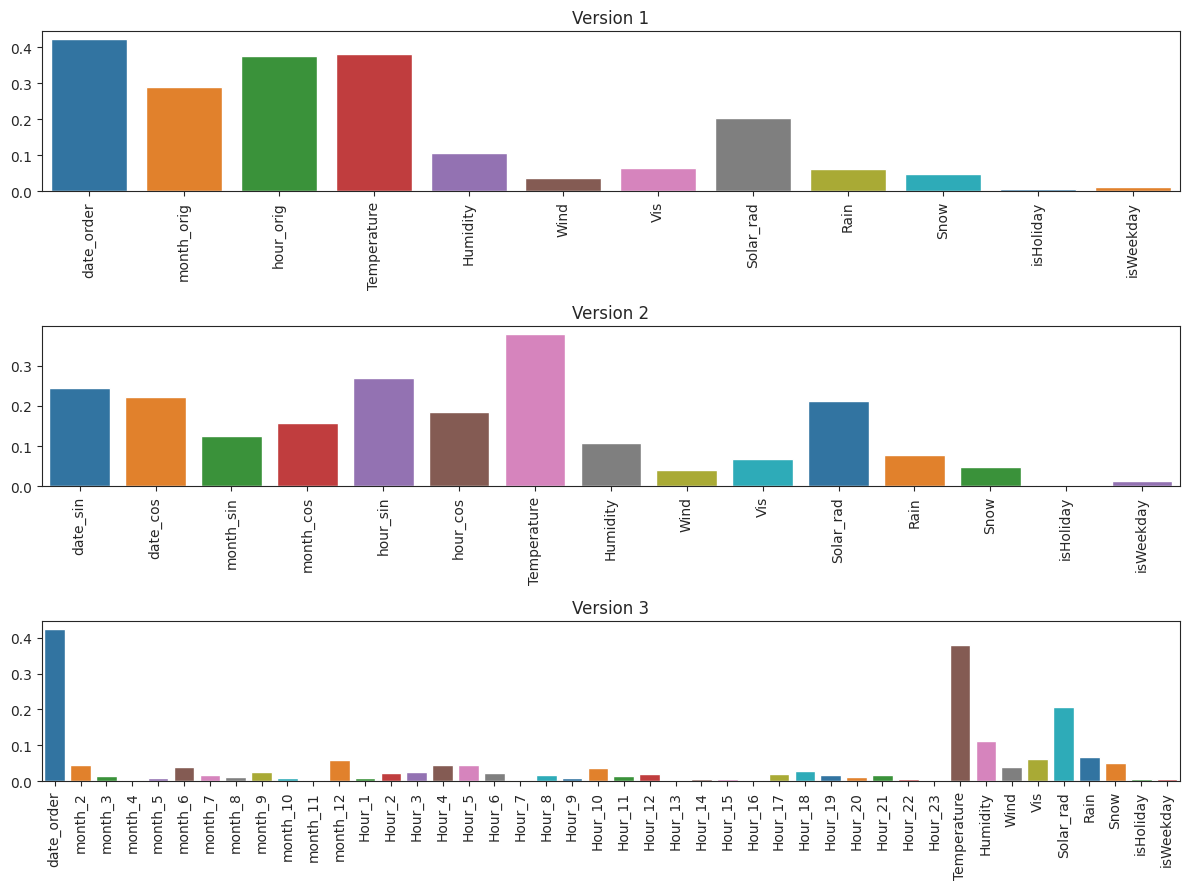

In [ ]:
# Setting list of features by version to be used in the feature selection
features_list = [features_v1, features_v2, features_v3]

# Setting up SelectKBest
best_attributes = SelectKBest(score_func=mutual_info_regression, k='all') # using mutual_info_regression due to categorical and numerica features present

# Create list to append scores per version
attribute_scores = []

# Get the training y values (do not vary by version)
y_train = df_train['Bike_Count']

# Plot the features and scores for each version
fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,9), dpi=100)
for i in range(len(features_list)):
  # Select training data from DataFrame based on list of attributes for version i+1
  X_selected = df_train[features_list[i]]
  # Fit and get scores
  best_attributes.fit(X_selected, y_train) # y values do not change for the different versions
  attribute_scores.append(best_attributes.scores_)
  # Plot figure for comparison
  sns.barplot(x=X_selected.columns, y=best_attributes.scores_, ax = axs[i], palette='tab10')
  axs[i].set(xlabel=None)
  axs[i].set_xticklabels(X_selected.columns, rotation=90)
  axs[i].set_title('Version %i' % (i+1))

plt.tight_layout()

In [ ]:
# Features in order of importance and their scores for the three versions from SelectKBest

for i in range(len(features_list)):
  df_features = pd.DataFrame({'features':features_list[i], 'scores':attribute_scores[i]})
  print("#######  Version %i  #######" % (i+1))
  print(df_features.sort_values(by=['scores'], ascending=False))
  print("\n")

#######  Version 1  #######
       features    scores
0    date_order  0.423080
3   Temperature  0.380818
2     hour_orig  0.376497
1    month_orig  0.289683
7     Solar_rad  0.202366
4      Humidity  0.106690
6           Vis  0.065369
8          Rain  0.062840
9          Snow  0.046408
5          Wind  0.036968
11    isWeekday  0.012566
10    isHoliday  0.006886


#######  Version 2  #######
       features    scores
6   Temperature  0.379532
4      hour_sin  0.268834
0      date_sin  0.243630
1      date_cos  0.223413
10    Solar_rad  0.212687
5      hour_cos  0.185735
3     month_cos  0.158154
2     month_sin  0.124276
7      Humidity  0.107989
11         Rain  0.077499
9           Vis  0.068882
12         Snow  0.047819
8          Wind  0.039664
14    isWeekday  0.012217
13    isHoliday  0.002887


#######  Version 3  #######
       features    scores
0    date_order  0.424210
35  Temperature  0.380224
39    Solar_rad  0.206144
36     Humidity  0.111056
40         Rain  0.066036
38

Note that:
* The time features are tagged as some of the most important features
* `Temperature`, `Solar Radiation`, and `Humidity` are the three most important weather-based attributes (out of the 7 given)
* The selection of holiday vs. non-holiday is also not within the most important attributes, but we should recall that only 5% of the data is tagged as holidays, so it is possible that the low statistics could impact the importance here.

### Recursive Feature Elimination

In [ ]:
# Setting list of features by version to be used in the feature selection
features_list = [features_v1, features_v2, features_v3]

# Selecting algorithm
model_RFE = DecisionTreeRegressor()

# Setting up the RFE
rfe = RFE(model_RFE, n_features_to_select=None)

# Create list to append ranking per version
attribute_ranking_rfe = []

# Get the training y values (do not vary by version)
y_train = df_train['Bike_Count']

# Get the features and ranking for each version
for i in range(len(features_list)):
  # Select training data from DataFrame based on list of attributes for version i+1
  X_selected = df_train[features_list[i]]
  # Fit and get scores
  rfe.fit(X_selected, y_train) # y values do not change for the different versions
  attribute_ranking_rfe.append(rfe.ranking_)
  df_features = pd.DataFrame({'features':features_list[i], 'ranking':rfe.ranking_})
  print("#######  Version %i  #######" % (i+1))
  print(df_features.sort_values(by=['ranking'], ascending=True))
  print("\n")


#######  Version 1  #######
       features  ranking
0    date_order        1
2     hour_orig        1
3   Temperature        1
4      Humidity        1
7     Solar_rad        1
11    isWeekday        1
8          Rain        2
5          Wind        3
6           Vis        4
10    isHoliday        5
1    month_orig        6
9          Snow        7


#######  Version 2  #######
       features  ranking
0      date_sin        1
1      date_cos        1
4      hour_sin        1
5      hour_cos        1
6   Temperature        1
7      Humidity        1
10    Solar_rad        1
14    isWeekday        2
11         Rain        3
9           Vis        4
8          Wind        5
13    isHoliday        6
3     month_cos        7
2     month_sin        8
12         Snow        9


#######  Version 3  #######
       features  ranking
0    date_order        1
27      Hour_16        1
28      Hour_17        1
29      Hour_18        1
30      Hour_19        1
31      Hour_20        1
32      Hour

Based on the RFE feature ranking above:
* We can see that again the versions can show differences regarding the time variables
* The weather-based variables that are ranked as **1** in all three versions are: `Temperature`, `Humidity`, `Solar Radiation`
* `Rain` has also been ranked relatively high
* The weekday tagging feature (`isWeekday`) also was ranked as more important than with SelectKBest.

### Tree-based feature selection - using ExtraTreesRegressor

In [ ]:
# Setting list of features by version to be used in the feature selection
features_list = [features_v1, features_v2, features_v3]

# Selecting algorithm
model_ET = ExtraTreesRegressor(n_estimators=100)

# Create list to append scores per version
attribute_scores_ET = []

# Get the training and test y values (do not vary by version)
y_train = df_train['Bike_Count']

# Get the features and scores for each version
for i in range(len(features_list)):
  # Select training and test data from DataFrame based on list of attributes for version i+1
  X_selected = df_train[features_list[i]]
  X_test = df_test[features_list[i]]
  # Fit and get scores
  model_ET.fit(X_selected, y_train) # y values do not change for the different versions
  # Append attribute importances
  attribute_scores_ET.append(model_ET.feature_importances_)
  df_features = pd.DataFrame({'features':features_list[i], 'score':model_ET.feature_importances_})
  print("#######  Version %i  #######" % (i+1))
  print(df_features.sort_values(by=['score'], ascending=False))
  print("\n")

#######  Version 1  #######
       features     score
2     hour_orig  0.329966
3   Temperature  0.224295
0    date_order  0.148644
4      Humidity  0.093269
7     Solar_rad  0.068345
1    month_orig  0.040888
11    isWeekday  0.034783
8          Rain  0.021751
6           Vis  0.019196
5          Wind  0.011784
10    isHoliday  0.006268
9          Snow  0.000812


#######  Version 2  #######
       features     score
4      hour_sin  0.259895
6   Temperature  0.226650
5      hour_cos  0.092491
7      Humidity  0.089908
0      date_sin  0.075620
3     month_cos  0.056192
10    Solar_rad  0.046179
14    isWeekday  0.037134
1      date_cos  0.032123
2     month_sin  0.031956
11         Rain  0.020392
9           Vis  0.015398
8          Wind  0.009072
13    isHoliday  0.006278
12         Snow  0.000713


#######  Version 3  #######
       features     score
35  Temperature  0.254190
36     Humidity  0.115905
0    date_order  0.092884
29      Hour_18  0.079205
43    isWeekday  0.041050
30

Using this method to assess feature importance, we can observe that:
* We can see that again the versions can show differences regarding the time variables
* The most important weather-based variables are again: `Temperature`, `Humidity`, `Solar Radiation`, and `Rain`
* The weekday tagging feature (`isWeekday`) also was ranked as more important than with SelectKBest, as in the RFE method.

### Conclusions from Feature Selection

Based on the observations we had from the three methods to assess feature importance in our training data, we can conclude that:
* The different methods are in overall agreement that `Temperature`, `Humidity`, `Solar Radiation`, and `Rain` are the most important weather-based features, and therefore will be selected for the modeling.
  * If we were considering pediction for future days, we would need probabilities for these features predictions, and therefore the model would need to be updated.
* The **month** related features are usually ranked lower than other time attributes. This makes sense, as we only have one year of data and the date from the start of the data set is providing better scores. Therefore, it seems redundant to include the month features when `date_order` variables should provide the necessary information.
* From the categorical features, `isWeekday` ranked close to the top weather-based features in the RFE and ExtraTrees methods. It is possible that `isHoliday` did not rank higher due to the lower statistics presented for this category. For now we will keep both.

Let's build below the updated list of features to be used in the modeling section.

In [ ]:
# Define selected features for modeling

#   Weather
selected_weather_attributes = ['Temperature', 'Humidity', 'Solar_rad', 'Rain']

#   Time
selected_time_attributes_v1 = ['date_order', 'hour_orig']
selected_time_attributes_v2 = ['date_sin', 'date_cos', 'hour_sin', 'hour_cos']
selected_time_attributes_v3 = ['date_order', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7',
                               'Hour_8', 'Hour_9', 'Hour_10','Hour_11','Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                               'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20','Hour_21', 'Hour_22', 'Hour_23']

#   Categorical
selected_cat_attributes_original = ['isWeekday', 'isHoliday']

# Creating list of total selected features per version
selected_features_v1 = selected_time_attributes_v1 + selected_weather_attributes + selected_cat_attributes_original
selected_features_v2 = selected_time_attributes_v2 + selected_weather_attributes + selected_cat_attributes_original
selected_features_v3 = selected_time_attributes_v3 + selected_weather_attributes + selected_cat_attributes_original

### Testing the selected features

Using the ExtraTrees estimator to assess the importance of the selected features.

In [ ]:
# Setting list of features by version
selected_features_list = [selected_features_v1, selected_features_v2, selected_features_v3]

# Selecting algorithm
model_ET = ExtraTreesRegressor(n_estimators=100)

# Create list to append scores per version
attribute_scores_ET = []

# Get the training and test y values (do not vary by version)
y_train = df_train['Bike_Count']

# Get the features and scores for each version
for i in range(len(selected_features_list)):
  # Select training and test data from DataFrame based on list of attributes for version i+1
  X_selected = df_train[selected_features_list[i]]
  X_test = df_test[selected_features_list[i]]
  # Fit and get scores
  model_ET.fit(X_selected, y_train) # y values do not change for the different versions
  # Append attribute importances
  attribute_scores_ET.append(model_ET.feature_importances_)
  df_features = pd.DataFrame({'features':selected_features_list[i], 'score':model_ET.feature_importances_})
  print("#######  Version %i  #######" % (i+1))
  print(df_features.sort_values(by=['score'], ascending=False))
  print("\n")

#######  Version 1  #######
      features     score
1    hour_orig  0.336383
2  Temperature  0.265021
0   date_order  0.156837
3     Humidity  0.108792
4    Solar_rad  0.068465
6    isWeekday  0.034357
5         Rain  0.023778
7    isHoliday  0.006366


#######  Version 2  #######
      features     score
4  Temperature  0.259033
2     hour_sin  0.258311
0     date_sin  0.103907
5     Humidity  0.096389
3     hour_cos  0.091017
1     date_cos  0.068038
6    Solar_rad  0.052197
8    isWeekday  0.037812
7         Rain  0.026714
9    isHoliday  0.006582


#######  Version 3  #######
       features     score
24  Temperature  0.265314
0    date_order  0.145682
25     Humidity  0.126716
18      Hour_18  0.079012
26    Solar_rad  0.049340
28    isWeekday  0.042471
19      Hour_19  0.040213
21      Hour_21  0.031443
20      Hour_20  0.031198
17      Hour_17  0.026424
8        Hour_8  0.026201
22      Hour_22  0.023667
27         Rain  0.019177
4        Hour_4  0.013253
5        Hour_5  0.011

## Cross Validation

Now that we have divided the data set and performed the feature selection, let's prepare the k pairs of training and validation sets for the cross validation. It makes sense to perform the cross validation in this exercise to compare performance of multiple algorithms without unblinding the test data set.

Similarly to the train/test split with Scikit-learn `GroupShuffleSplit`, we will split the training data set in train/validate sets to perform the cross validation.

Note that:
* We will not use `KFold` due to its inability to keep all entries from the same day (each day has 24 entries - for the 24 hours) in the same set (either train or validate).
* `GroupKFold` could also be used in this case. However, `GroupShuffleSplit` was chosen to try to keep well distributed validation sets. `GroupKFold` would not repeat a group (day) in different validation sets, and we have low statistics of some categories (e.g., holidays).

In [ ]:
# Using GroupShuffleSplit to divide the data between train and validation sets

# Number of split and fraction of validation set
n_iterations = 5 # number of training and validation sets
valFraction = 1/n_iterations

# Set up split
gss_cv = GroupShuffleSplit(n_splits=n_iterations, random_state=7, test_size=valFraction)

# Get group of days (days since start of data set) in the training set - which group (day) each entry is part of
# groups_cv will be recalled in cross_val_score
groups_cv = df_train['date_order'].values


## Scaling: Normalization vs. Padronization

We will test two scaling methods to try to improve the algorithms performances:
* Standardization (StandardScaler)
* Normalization (MinMaxScaler)

However, we should keep in mind that since we expect the best performance to be from tree-based algorithms, the scalers might not have a substantial performance improvement in the best models.

In [ ]:
# Scaling transformations that will be tested in the modeling section - to be added to pipelines

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Modeling

For the modeling of this regression problem, we have selected the following algorithms to build our base models:
* Decision Tree Regression
* K-Nearest Neighbors (KNN)
* Support Vector Machines (SVM) - SVR
* Linear Regression (ordinary least squares)
* Linear Regression with Ridge regularization (l2 regularization)
* Linear Regression with Lasso regularization (l1 regularization)

In addition to the above base algorithms, we will aim to compare more complex modeling with ensemble methods as well (to be discussed later).

Although we will be testing a variety of algorithms, the tree-based algorithms (and ensembles) will likely have the best results due to the non-linearities observed.

We will use the R^2 values for the comparison with cross validation.

## Data set up

In [ ]:
# Setting up the X arrays for training and testing
#  V1
X_train_v1 = df_train[selected_features_v1].values
X_test_v1 = df_test[selected_features_v1].values
#  V2
X_train_v2 = df_train[selected_features_v2].values
X_test_v2 = df_test[selected_features_v2].values
#  V3
X_train_v3 = df_train[selected_features_v3].values
X_test_v3 = df_test[selected_features_v3].values

# Recalling y arrays for training and testing
y_train = df_train['Bike_Count'].values
y_test = df_test['Bike_Count'].values


## Base models

We will not perform any initial hyperparameter setting to the base models. Once we choose our ensemble algorithms and have a better idea of the  best models, we will may initialize and perform the optimization.

In [ ]:
# Setting up the pipelines

# Define global random seed
np.random.seed(7)

# Lists of pipelines
pipelines_base = []

# Base algorithms
algorithms = [('CART', DecisionTreeRegressor()),
              ('KNN', KNeighborsRegressor()),
              ('SVM', SVR()),
              ('LinearR', LinearRegression()),
              ('Ridge', Ridge()),
              ('Lasso',Lasso())]

# Create pipelines for each base algorithm without scaling, with standard scaling, and with MinMax scaling (normalization)
for name, algorithm in algorithms:
  # No scaling
  pipelines_base.append((name, Pipeline([(name, algorithm)])))
  # Standard scaling
  pipelines_base.append((name+"_std", Pipeline([standard_scaler, (name, algorithm)])))
  # MinMax Scaling (Normalization)
  pipelines_base.append((name+"_norm", Pipeline([min_max_scaler, (name, algorithm)])))

### Models comparison

**Features in version 1 of data (V1)**

In [ ]:
# v1

# Setting dataframe of names and result scores of models
df_CrossVal_v1 = pd.DataFrame({'Model':[], 'R2':[]})

# Setting scoring for comparison
scoring = 'r2'

for name, model in pipelines_base:
  cv_results_base = cross_val_score(model, X_train_v1, y_train, cv=gss_cv, groups=groups_cv, scoring=scoring)
  # Looping over number of iterations in cross validation
  for cv_score in cv_results_base:
    df_CrossVal_v1.loc[len(df_CrossVal_v1.index)] = [name, cv_score]


R2          
                  mean       std
Model                           
CART          0.842760  0.018480
CART_norm     0.842981  0.013102
CART_std      0.842068  0.016380
KNN           0.690369  0.021407
KNN_norm      0.839898  0.015741
KNN_std       0.836640  0.017255
Lasso         0.533698  0.014445
Lasso_norm    0.528573  0.014442
Lasso_std     0.533207  0.013411
LinearR       0.533458  0.013357
LinearR_norm  0.533458  0.013357
LinearR_std   0.533458  0.013357
Ridge         0.533482  0.013399
Ridge_norm    0.532729  0.013438
Ridge_std     0.533451  0.013359
SVM           0.151925  0.045275
SVM_norm      0.229739  0.045478
SVM_std       0.309349  0.029837

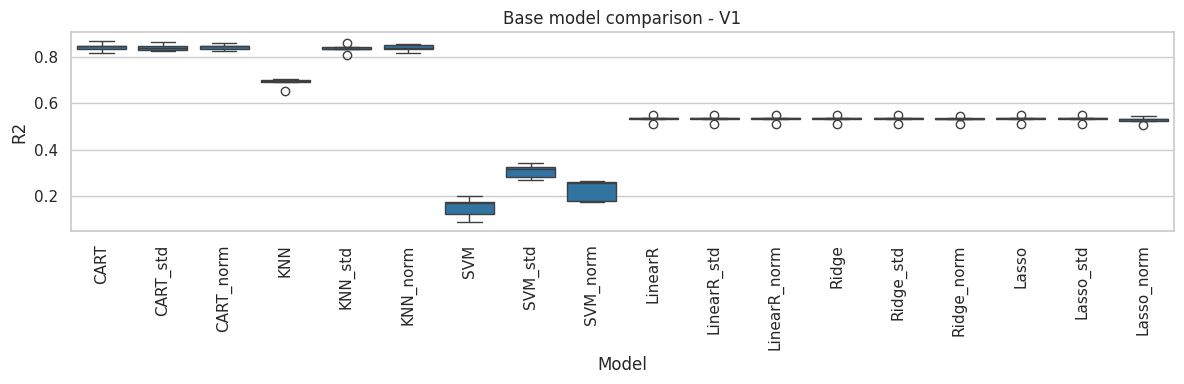

In [ ]:
# Set up figure
plt.figure(figsize=(12,4))
sns.set_theme(style="whitegrid")

# Boxplot of cross validation R2 scores for each model
sns.boxplot(data=df_CrossVal_v1, x="Model", y="R2", color="tab:blue")
plt.xticks(rotation=90)
plt.title('Base model comparison - V1')

plt.tight_layout()

df_CrossVal_v1.groupby('Model').agg(['mean','std'])

**Features in version 2 of data (V2)**

In [ ]:
# v2

# Setting dataframe of names and result scores of models
df_CrossVal_v2 = pd.DataFrame({'Model':[], 'R2':[]})

# Setting scoring for comparison
scoring = 'r2'

for name, model in pipelines_base:
  cv_results_base = cross_val_score(model, X_train_v2, y_train, cv=gss_cv, groups=groups_cv, scoring=scoring)
  # Looping over number of iterations in cross validation
  for cv_score in cv_results_base:
    df_CrossVal_v2.loc[len(df_CrossVal_v2.index)] = [name, cv_score]


R2          
                  mean       std
Model                           
CART          0.850194  0.017035
CART_norm     0.848445  0.019128
CART_std      0.845984  0.014057
KNN           0.636484  0.023769
KNN_norm      0.871495  0.012221
KNN_std       0.873264  0.015977
Lasso         0.520060  0.013152
Lasso_norm    0.514823  0.015929
Lasso_std     0.519938  0.013635
LinearR       0.520284  0.013338
LinearR_norm  0.520284  0.013338
LinearR_std   0.520284  0.013338
Ridge         0.520292  0.013310
Ridge_norm    0.519471  0.013731
Ridge_std     0.520279  0.013343
SVM           0.121130  0.051969
SVM_norm      0.217307  0.044013
SVM_std       0.259748  0.036524

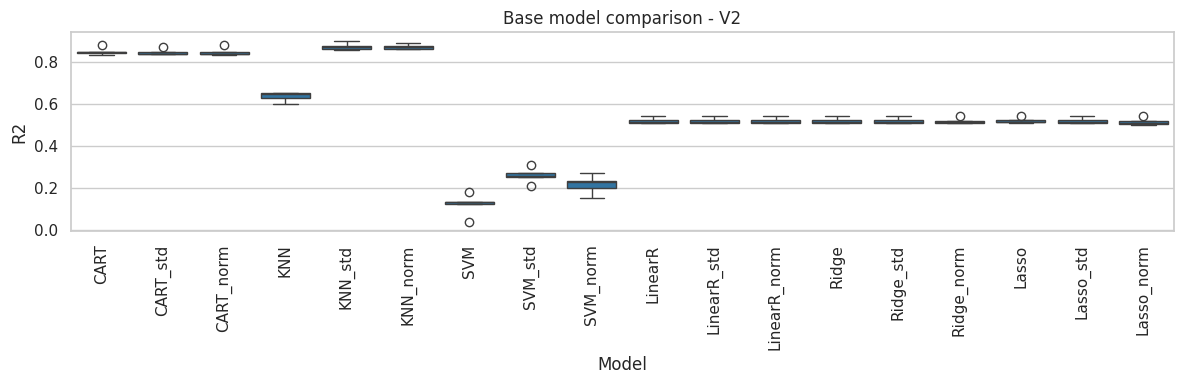

In [ ]:
# Set up figure
plt.figure(figsize=(12,4))
sns.set_theme(style="whitegrid")

# Boxplot of cross validation R2 scores for each model
sns.boxplot(data=df_CrossVal_v2, x="Model", y="R2", color="tab:blue")
plt.xticks(rotation=90)
plt.title('Base model comparison - V2')

plt.tight_layout()

df_CrossVal_v2.groupby('Model').agg(['mean','std'])

**Features in version 3 of data (V3)**

In [ ]:
# v3

# Setting dataframe of names and result scores of models
df_CrossVal_v3 = pd.DataFrame({'Model':[], 'R2':[]})

# Setting scoring for comparison
scoring = 'r2'

for name, model in pipelines_base:
  cv_results_base = cross_val_score(model, X_train_v3, y_train, cv=gss_cv, groups=groups_cv, scoring=scoring)
  # Looping over number of iterations in cross validation
  for cv_score in cv_results_base:
    df_CrossVal_v3.loc[len(df_CrossVal_v3.index)] = [name, cv_score]


R2          
                  mean       std
Model                           
CART          0.829046  0.022872
CART_norm     0.829884  0.023823
CART_std      0.829368  0.023175
KNN           0.474160  0.029287
KNN_norm      0.867690  0.023386
KNN_std       0.871498  0.023712
Lasso         0.654106  0.016943
Lasso_norm    0.649709  0.017619
Lasso_std     0.658096  0.014684
LinearR       0.659070  0.014400
LinearR_norm  0.659070  0.014400
LinearR_std   0.659070  0.014400
Ridge         0.658883  0.014482
Ridge_norm    0.658300  0.014593
Ridge_std     0.659061  0.014402
SVM           0.133628  0.047417
SVM_norm      0.042303  0.048520
SVM_std       0.037515  0.047268

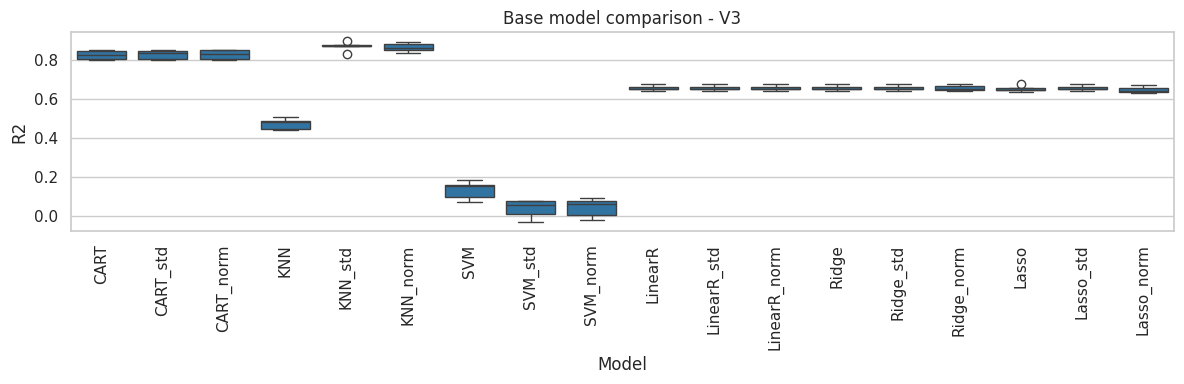

In [ ]:
# Set up figure
plt.figure(figsize=(12,4))
sns.set_theme(style="whitegrid")

# Boxplot of cross validation R2 scores for each model
sns.boxplot(data=df_CrossVal_v3, x="Model", y="R2", color="tab:blue")
plt.xticks(rotation=90)
plt.title('Base model comparison - V3')

plt.tight_layout()

df_CrossVal_v3.groupby('Model').agg(['mean','std'])

### Takeaways

* As observed in the training of the three versions of the data set above, we can confirm our earlier hypothesis of the high non-linearity affecting the performance of the linear models. From all the base models tested, it is clear that the Decision Tree and the K Nearest Neighbors algorthms are the ones that perform the best. It seems that the encoding applied in **V3** to try to more closely address the non-lineariry was not suficient, although it was able to increase the R^2 from ~0.5 (in V1 and V2) to ~0.65 (V3).

* There was considered underfitting for the linear regressions models (including for Lasso and Ridge regularizations) and for the SVM regressor (the worst fitting performance). Clearly there are other data treatments that would be required to properly train the model with these algorithms.

* Given the preference for the KNN and tree-based algorithms, we will now build our Ensembles accordingly, selecting the V2 of our training data set, given the improved results compared to V1 for these algorithms.


In [ ]:
X_train = X_train_v2
X_test = X_test_v2
selected_features = selected_features_v2

## Ensembles

Given the results from the base models observed above, we will test algorithms that are based on decision trees. The ones to be tested are the following:
* Bagging:
  * Bagging Regressor
  * RandomForest Regressor
  * ExtraTrees Regressor
* Boost:
  * AdaBoost Regressor
  * GradientBoost Regressor
* Voting:
  * Voting Regressor

Let's also include the KNN and Decision Tree models below to have all the relevant cross validation results together for comparison. Note that some initial parameter setting will be necessary for some ensembles.

In [ ]:
# Setting up the pipelines

# Define global random seed
np.random.seed(7)

# Lists of pipelines
pipelines_all = []

# Defining initial parameters
num_trees = 100
max_features = 5

# Defining the base regressors
tree_base = DecisionTreeRegressor()
voting_base = [('CART', DecisionTreeRegressor()),
               ('KNN', KNeighborsRegressor()),
               ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features))]
               #('GB', GradientBoostingRegressor(n_estimators=num_trees))]

# Algorithms: 2 base + 6 ensembles
algorithms = [('CART', DecisionTreeRegressor()),
              ('KNN', KNeighborsRegressor()),
              ('Bagging', BaggingRegressor(base_estimator=tree_base, n_estimators=num_trees)),
              ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features)),
              ('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features)),
              ('Ada', AdaBoostRegressor(n_estimators=num_trees)),
              ('GB', GradientBoostingRegressor(n_estimators=num_trees)),
              ('Voting', VotingRegressor(voting_base))]

# Create pipelines for each algorithm without scaling, with standard scaling, and with MinMax scaling (normalization)
for name, algorithm in algorithms:
  # No scaling
  pipelines_all.append((name, Pipeline([(name, algorithm)])))
  # Standard scaling
  pipelines_all.append((name+"_std", Pipeline([standard_scaler, (name, algorithm)])))
  # MinMax Scaling (Normalization)
  pipelines_all.append((name+"_norm", Pipeline([min_max_scaler, (name, algorithm)])))

### Models comparison

In [ ]:
# Setting dataframe of names and result scores of models
df_CrossVal = pd.DataFrame({'Model':[], 'R2':[]})

# Setting scoring for comparison
scoring = 'r2'

for name, model in pipelines_all:
  cv_results = cross_val_score(model, X_train, y_train, cv=gss_cv, groups=groups_cv, scoring=scoring)
  # Looping over number of iterations in cross validation
  for cv_score in cv_results:
    df_CrossVal.loc[len(df_CrossVal.index)] = [name, cv_score]


R2          
                  mean       std
Model                           
Ada           0.578295  0.045549
Ada_norm      0.581650  0.023503
Ada_std       0.593748  0.047116
Bagging       0.911421  0.013149
Bagging_norm  0.912597  0.011960
Bagging_std   0.911132  0.011746
CART          0.848208  0.021432
CART_norm     0.847644  0.018496
CART_std      0.845497  0.013593
ET            0.918280  0.009366
ET_norm       0.918039  0.010587
ET_std        0.917751  0.009433
GB            0.866893  0.009291
GB_norm       0.867418  0.008921
GB_std        0.867543  0.008756
KNN           0.636484  0.023769
KNN_norm      0.871495  0.012221
KNN_std       0.873264  0.015977
RF            0.916533  0.012094
RF_norm       0.915533  0.010361
RF_std        0.915222  0.010339
Voting        0.875650  0.011664
Voting_norm   0.909048  0.008351
Voting_std    0.908923  0.009849

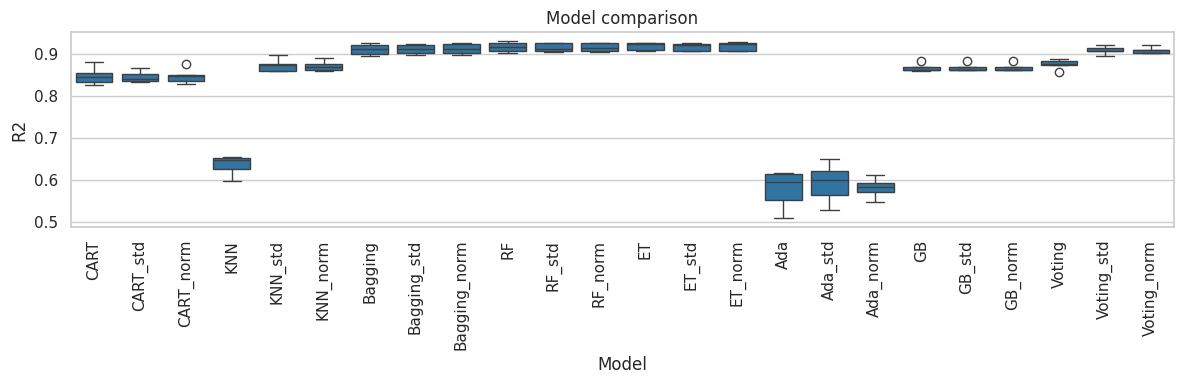

In [ ]:
# Set up figure
plt.figure(figsize=(12,4))
sns.set_theme(style="whitegrid")

# Boxplot of cross validation R2 scores for each model
sns.boxplot(data=df_CrossVal, x="Model", y="R2", color="tab:blue")
plt.xticks(rotation=90)
plt.title('Model comparison')

plt.tight_layout()

df_CrossVal.groupby('Model').agg(['mean','std'])

### Takeaways

As we can observe, we have the following models with R^2 above 90%:
* Bagging (not scaled, with Standard Scaling, and with MinMax Scaling)
* RandomForest (not scaled, with Standard Scaling, and with MinMax Scaling)
* ExtraTrees (not scaled, with Standard Scaling, and with MinMax Scaling)
* Voting (with Standard Scaling and with MinMax Scaling)

The tree-based models do not show much variation among them. Small variations might come from tunning the hyperparameters.
For the hyperparameter optimization, let's choose the models based on **`KNN`**, **`ExtraTrees`**, and **`RandomForest`**. We will not choose the Voting model since it will likely not be the best performer, and due to the time it would take to run the the optimization.


## Hyperparameter tuning

As mentioned above, we will tune the following models:
* KNN
* ExtraTrees
* RandomForest

However, given the small difference and the time it takes to test the parameter space, we will test only the MinMax scaling version of the model for the ExtraTrees and the Voting algorithms.

In [ ]:
# KNN

# Define global random seed
np.random.seed(7)

# Lists of pipelines
pipelines_knn = []

# Define pipeline components
knn = ('KNN', KNeighborsRegressor())

pipelines_knn.append(('KNN', Pipeline([knn])))
pipelines_knn.append(('KNN-std', Pipeline([standard_scaler, knn])))
pipelines_knn.append(('KNN-norm', Pipeline([min_max_scaler, knn])))

# Define the parameters to be tested
param_grid = {
    'KNN__n_neighbors': [5,7,9,11,13,15,17,19],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
    'KNN__weights': ["uniform", "distance"]
}

# Setting scoring for comparison
scoring = 'r2'

# Run the GridSearchCV
for name, model in pipelines_knn:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=gss_cv)
    grid.fit(X_train, y_train, groups=groups_cv)
    # Print the best parameter configuration for each model
    print("Model: %s - R^2: %f - Parameters: %s" % (name, grid.best_score_, grid.best_params_))

Model: KNN - R^2: 0.708827 - Parameters: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9, 'KNN__weights': 'distance'}
Model: KNN-std - R^2: 0.892144 - Parameters: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9, 'KNN__weights': 'distance'}
Model: KNN-norm - R^2: 0.885889 - Parameters: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7, 'KNN__weights': 'distance'}


Note: It can take more than 30 min to run GridSearchCV for ExtraTrees. For a quicker check, select n_estimators = 150, max_features = 10, max_depth = 15.

In [ ]:
# ExtraTrees

# Define global random seed
np.random.seed(7)

# Lists of pipelines
pipelines_et = []

# Define pipeline component
et = ('ExtraTrees', ExtraTreesRegressor())

pipelines_et.append(('ExtraTrees', Pipeline([et])))
pipelines_et.append(('ExtraTrees-std', Pipeline([standard_scaler, et])))
pipelines_et.append(('ExtraTrees-norm', Pipeline([min_max_scaler, et])))

# Define the parameters to be tested
param_grid = {
    'ExtraTrees__n_estimators': [100, 150, 200, 300],
    'ExtraTrees__max_features': [None, 5, 7, 10],
    'ExtraTrees__max_depth': [None, 5, 10, 15, 20]
}

# Setting scoring for comparison
scoring = 'r2'

# Run the GridSearchCV
for name, model in pipelines_et:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=gss_cv)
    grid.fit(X_train, y_train, groups=groups_cv)
    # Print the best parameter configuration for each model
    print("Model: %s - R^2: %f - Parameters: %s" % (name, grid.best_score_, grid.best_params_))

Model: ExtraTrees - R^2: 0.922581 - Parameters: {'ExtraTrees__max_depth': 15, 'ExtraTrees__max_features': None, 'ExtraTrees__n_estimators': 150}
Model: ExtraTrees-std - R^2: 0.922429 - Parameters: {'ExtraTrees__max_depth': 15, 'ExtraTrees__max_features': None, 'ExtraTrees__n_estimators': 300}
Model: ExtraTrees-norm - R^2: 0.922681 - Parameters: {'ExtraTrees__max_depth': 15, 'ExtraTrees__max_features': 10, 'ExtraTrees__n_estimators': 150}


Note: It can take more than 40 min to run GridSearchCV for RandomForest. For a quicker check, select n_estimators = 300, max_features = 7, max_depth = None.

In [ ]:
# RandomForest

# Define global random seed
np.random.seed(7)

# Lists of pipelines
pipelines_rf = []

# Define pipeline components
rf = ('RandomForest', RandomForestRegressor())

pipelines_rf.append(('RandomForest', Pipeline([rf])))
pipelines_rf.append(('RandomForest-std', Pipeline([standard_scaler, rf])))
pipelines_rf.append(('RandomForest-norm', Pipeline([min_max_scaler, rf])))

# Define the parameters to be tested
param_grid = {
    'RandomForest__n_estimators': [100, 150, 200, 300],
    'RandomForest__max_features': [None, 5, 7, 10],
    'RandomForest__max_depth': [None, 5, 10, 15, 20]
}

# Setting scoring for comparison
scoring = 'r2'

# Run the GridSearchCV
for name, model in pipelines_rf:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=gss_cv)
    grid.fit(X_train, y_train, groups=groups_cv)
    # Print the best parameter configuration for each model
    print("Model: %s - R^2: %f - Parameters: %s" % (name, grid.best_score_, grid.best_params_))

Model: RandomForest - R^2: 0.916073 - Parameters: {'RandomForest__max_depth': 20, 'RandomForest__max_features': 5, 'RandomForest__n_estimators': 300}
Model: RandomForest-std - R^2: 0.916997 - Parameters: {'RandomForest__max_depth': 20, 'RandomForest__max_features': 5, 'RandomForest__n_estimators': 150}
Model: RandomForest-norm - R^2: 0.917312 - Parameters: {'RandomForest__max_depth': None, 'RandomForest__max_features': 7, 'RandomForest__n_estimators': 300}


# Results

## Model Selection and training

Based on the comparison of models we performed and the hyperparameter optimization, we can see that the ExtraTrees model obtained the best performance. Therefore, we will choose this algorithm (with the MinMax scaling), with the updated initial parameters found during the optimization, to train the full training set (note that we have selected the V2 of the features, now set to X_train), and predict the bike demand for the X_test set (still blind at this moment). We will then compare the prediction to the real values and evaluate the performance (based on the MSE, RMSE, and R^2).

In [88]:
# Setting up the model pipeline

# Define global random seed
np.random.seed(7)

# Defining initial parameters - based on hyperparameter optimization
num_trees = 150
max_features = 10
max_depth = 15

# Create model pipeline with initial parameters and selected scaler
model = Pipeline([min_max_scaler, ('ExtraTrees', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features, max_depth=max_depth))])

# Fit model to entire training set
model.fit(X_train,y_train)


Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('ExtraTrees',
                 ExtraTreesRegressor(max_depth=15, max_features=10,
                                     n_estimators=150))])

In [89]:
# Prediction

# Predict bike demand for the blind data (test data set)
prediction = model.predict(X_test)

# Get Mean Squared Error (MSE), RMSE, and Rˆ2
mse = mean_squared_error(y_test, prediction)
rmse = np.sqrt(abs(mse))
r2 = r2_score(y_test, prediction)

# Print results
print("MSE: %0.2f" % mse)
print("RMSE: %0.2f" % rmse)
print("R^2: %0.3f" % r2)


MSE: 31829.14
RMSE: 178.41
R^2: 0.913


We can observe that the Rˆ2 is slightely smaller than that obtained during the training. However, the difference DOES NOT indicate overfitting. The result and performance are as we expected.

## Analysing the results

For a deeper analysis of the results, let's create a DataFrame with the input features, the real target (bike demand - `Bike_Count`), the prediction from the model above (`Bike_Prediction`), and the difference between them (`Residuals`).

In [111]:
# Comparing prediction to real values

# Create DataFrame with selected features (and additional variables for visualization), real values of Bike_Count and the prediction
df_result = df_test[selected_features]
df_result["date"] = df_test["date_order"]
df_result["hour"] = df_test["hour_orig"]
df_result["month"] = df_test["month_orig"]
df_result["seasons"] = df_test["Seasons"]
df_result["week_day"] = df_test["week_day"]

df_result['Bike_Count'] = y_test
df_result['Bike_Prediction'] = prediction
df_result['Residuals'] = df_result['Bike_Prediction'].values - df_result['Bike_Count'].values


In [112]:
df_result.head(1)

date_sin  date_cos  hour_sin  hour_cos  Temperature  Humidity  Solar_rad  \
48  0.034422  0.999407       0.0       1.0          4.0        58        0.0   

    Rain  isWeekday  isHoliday  date  hour  month seasons week_day  \
48   0.0          0          0     2     0     12  Winter   Sunday   

    Bike_Count  Bike_Prediction  Residuals  
48         342       405.954398  63.954398

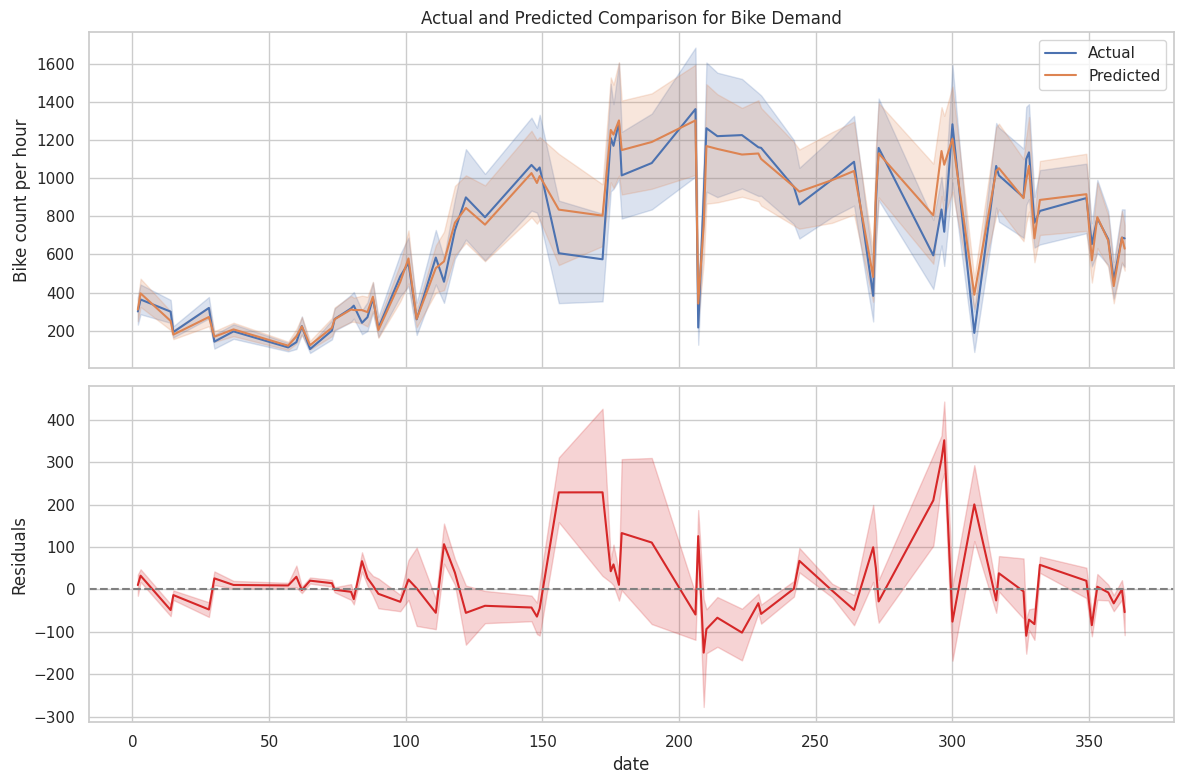

In [92]:
# Plotting the timeseries results - Days

# Set up figure and subplots
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,8), dpi=100, sharex=True)

# Plot
sns.lineplot(data=df_result, x='date', y='Bike_Count', ax=axs[0], palette='tab10', label='Actual') # Actual
sns.lineplot(data=df_result, x='date', y='Bike_Prediction', ax=axs[0], palette='tab10', label='Predicted') # Prediction
sns.lineplot(data=df_result, x='date', y='Residuals', ax=axs[1], color='tab:red')

axs[0].set_title("Actual and Predicted Comparison for Bike Demand")
axs[0].set_ylabel("Bike count per hour")
axs[0].legend()
axs[1].axhline(y=0, color='gray', linestyle='--')

plt.tight_layout()

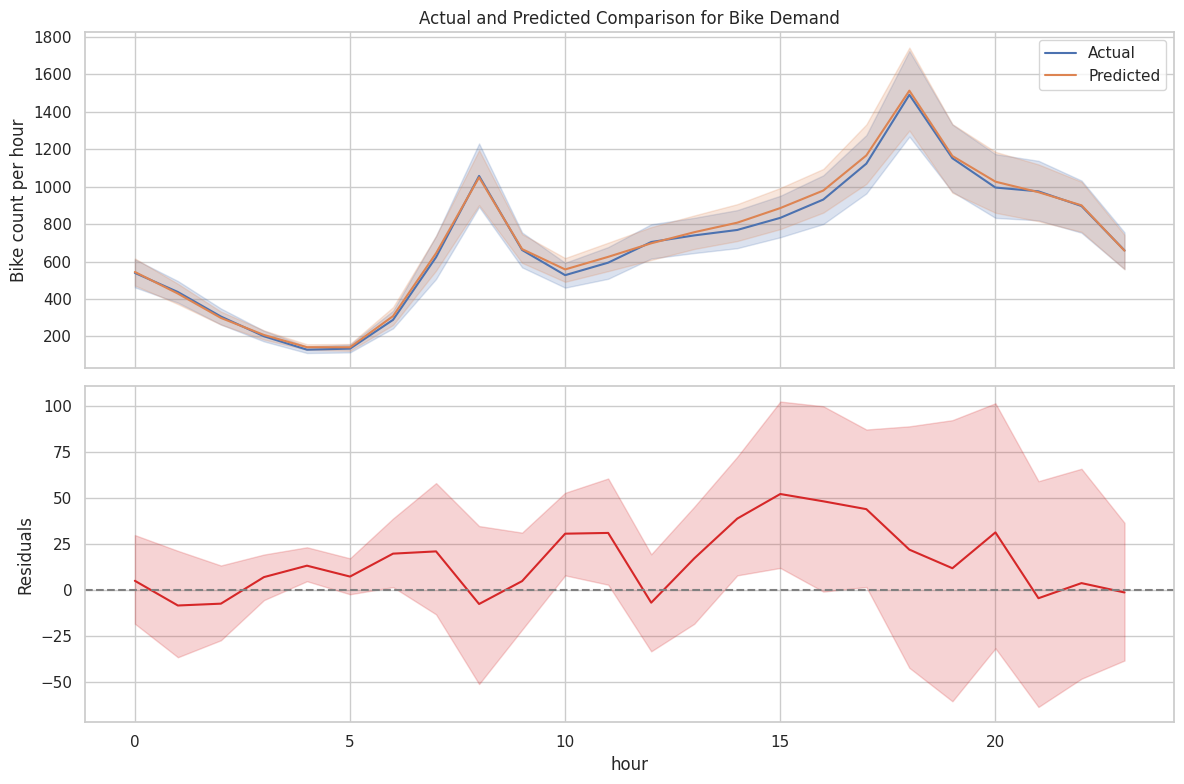

In [93]:
# Plotting the timeseries results - Hours

# Set up figure and subplots
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,8), dpi=100, sharex=True)

# Plot
sns.lineplot(data=df_result, x='hour', y='Bike_Count', ax=axs[0], palette='tab10', label='Actual')
sns.lineplot(data=df_result, x='hour', y='Bike_Prediction', ax=axs[0], palette='tab10', label='Predicted')
sns.lineplot(data=df_result, x='hour', y='Residuals', ax=axs[1], color='tab:red')

axs[0].set_title("Actual and Predicted Comparison for Bike Demand")
axs[0].set_ylabel("Bike count per hour")
axs[0].legend()
axs[1].axhline(y=0, color='grey', linestyle='--')

plt.tight_layout()

Based on the daily and hourly plots above, we can see that the model tends to predict are higher demand in bikes than actual necessary (residuals = predicted - actual):
* During the year, the days with higher discrepancy can be found between days 150-200 and 370-330
* From the perspective of hours of the day, the greater discrepancy and variation in the distribution can be found for afternoon times, in particular closer to the 18h peak

Let's take a deeper look on the possible causes by first looking at the features' importances.

In [100]:
# Checking the importance of the selected training features

for i in range(len(selected_features)):
  print("%s: %0.3f" % (selected_features[i], model[1].feature_importances_[i]))

date_sin: 0.099
date_cos: 0.060
hour_sin: 0.261
hour_cos: 0.092
Temperature: 0.269
Humidity: 0.094
Solar_rad: 0.053
Rain: 0.026
isWeekday: 0.039
isHoliday: 0.006


The most important features are, therefore: `Temperature` and `hour_sin` (sine component of the hour).

Since the hour is important for the modeling, let's investigate how the hourly distribution changes based on other features.

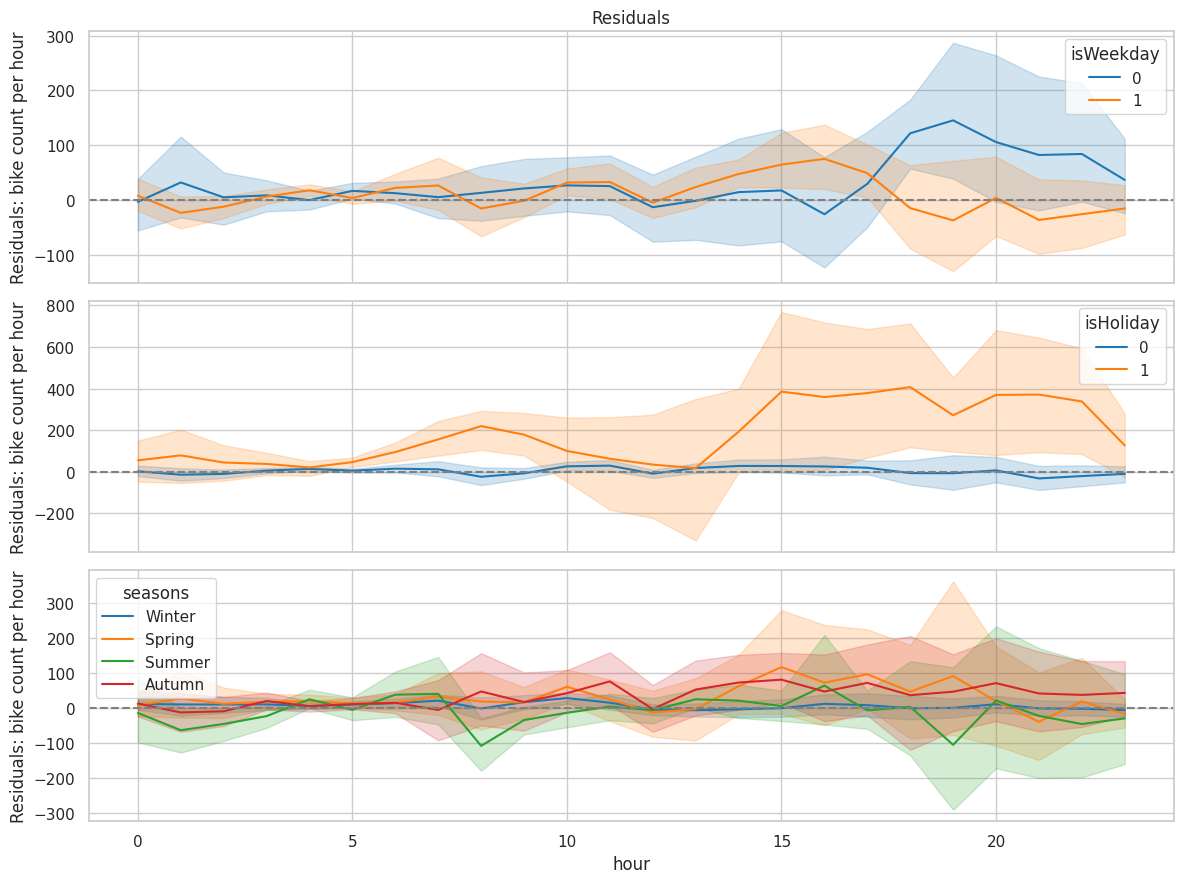

In [110]:
# Plotting

# Set up figure and subplots
fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(12,9), dpi=100, sharex=True)

# Plot
sns.lineplot(data=df_result, x='hour', y='Residuals', ax=axs[0], palette='tab10', hue='isWeekday')
sns.lineplot(data=df_result, x='hour', y='Residuals', ax=axs[1], palette='tab10', hue='isHoliday')
sns.lineplot(data=df_result, x='hour', y='Residuals', ax=axs[2], palette='tab10', hue='seasons')

axs[0].set_title("Residuals")
axs[0].set_ylabel("Residuals: bike count per hour")
axs[1].set_ylabel("Residuals: bike count per hour")
axs[2].set_ylabel("Residuals: bike count per hour")
axs[0].axhline(y=0, color='grey', linestyle='--')
axs[1].axhline(y=0, color='grey', linestyle='--')
axs[2].axhline(y=0, color='grey', linestyle='--')

plt.tight_layout()

Based on the observations above, it seems like the model does not predict weekends and holidays as well as weekday. However, we should keep in mind that the statistics for such days are considerably lower than for regular weekdays. Let's look at these statistics below.

In [168]:
# Daily average of the number of bikes (actual and predicted)

# Group by day
df_result_byDate = df_result.groupby('date')[['isHoliday', 'isWeekday', 'Rain', 'Temperature', 'Bike_Count','Bike_Prediction']].agg({'isHoliday':'mean', 'isWeekday':'mean', 'Rain':'mean', 'Temperature':'mean', 'Bike_Count':['mean','std'], 'Bike_Prediction':['mean','std']})

# Create residuals of daily average
df_result_byDate['Daily_Avg_Residuals'] = df_result_byDate[('Bike_Prediction', 'mean')] - df_result_byDate[('Bike_Count', 'mean')]

df_result_byDate.sort_values(by=('Daily_Avg_Residuals'), ascending=False).head(20)

isHoliday isWeekday      Rain Temperature   Bike_Count              \
          mean      mean      mean        mean         mean         std   
date                                                                      
297        1.0       1.0  0.000000   17.820833   719.125000  460.359813   
296        1.0       0.0  0.000000   19.412500   835.833333  462.710132   
172        1.0       1.0  0.375000   18.195833   574.583333  605.038405   
156        0.0       0.0  0.916667   16.916667   606.500000  691.025703   
293        0.0       1.0  0.208333   19.050000   595.083333  469.707394   
308        0.0       1.0  1.479167   17.095833   188.416667  258.286143   
179        0.0       1.0  0.041667   21.537500  1014.791667  572.206103   
207        0.0       1.0  2.979167   22.904167   216.666667  273.871863   
190        0.0       0.0  0.020833   23.683333  1079.625000  637.113246   
114        0.0       0.0  0.000000    9.625000   456.791667  299.881133   
271        0.0       1.0  1.791667   25.012500   382.666667  371.924217   
244        0.0       1.0  0.000000   33.741667   862.208333  478.688878   
84         0.0       1.0  0.170833    3.950000   241.541667  162.044272   
176        0.0       0.0  0.000000   21.479167  1169.958333  593.937376   
332        0.0       1.0  0.000000    7.395833   828.208333  495.945034   
272        0.0       1.0  0.395833   25.450000   873.291667  606.534882   
175        0.0       1.0  0.000000   19.754167  1210.708333  691.398864   
118        0.0       1.0  0.000000   15.545833   727.083333  418.412831   
317        0.0       0.0  0.000000   12.995833  1014.541667  622.149568   
3          0.0       1.0  0.004167   -0.304167   363.708333  213.796425   

     Bike_Prediction             Daily_Avg_Residuals  
                mean         std                      
date                                                  
297      1070.725831  649.591053          351.600831  
296      1142.568807  600.755274          306.735473  
172       803.429899  391.015635          228.846566  
156       835.199257  736.237389          228.699257  
293       805.078847  641.951002          209.995513  
308       388.840152  210.347157          200.423485  
179      1147.561575  672.568822          132.769909  
207       342.233590  230.137623          125.566923  
190      1190.030900  658.119684          110.405900  
114       563.347715  401.983237          106.556048  
271       481.947570  342.905079           99.280903  
244       929.458501  541.268051           67.250167  
84        308.031361  191.859299           66.489694  
176      1228.812731  701.890430           58.854398  
332       886.051516  507.624197           57.843183  
272       922.916890  620.269666           49.625223  
175      1253.403279  724.722459           42.694945  
118       766.433136  461.489927           39.349803  
317      1052.482399  569.829389           37.940733  
3         395.969384  192.629502           32.261050

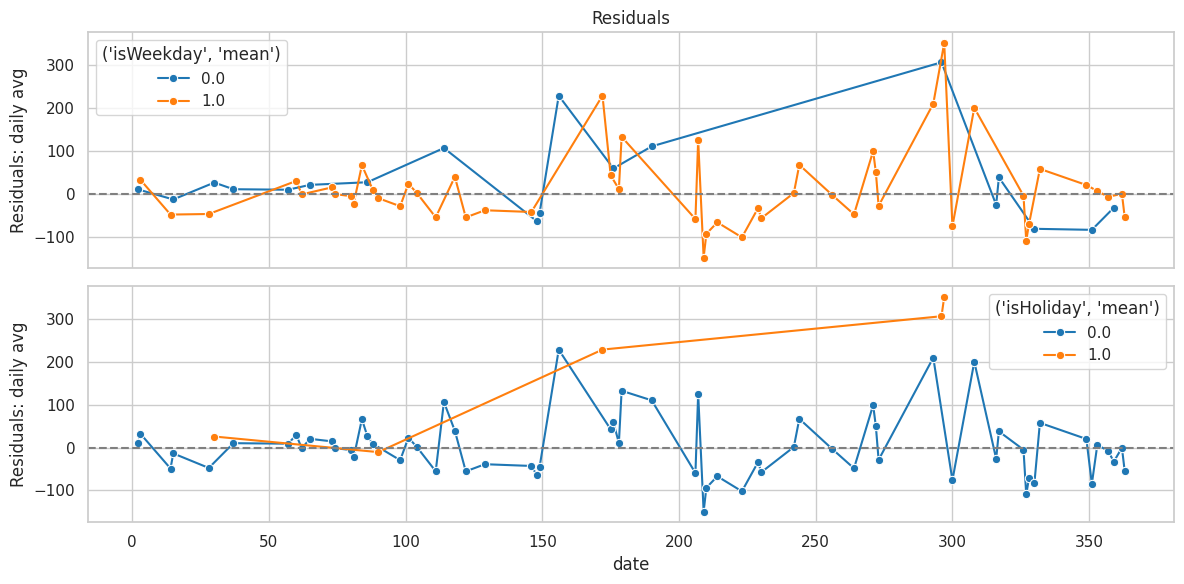

In [136]:
# Plotting

# Set up figure and subplots
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,6), dpi=100, sharex=True)

# Plot the residuals of the daily average
sns.lineplot(data=df_result_byDate, x='date', y='Daily_Avg_Residuals', ax=axs[0], palette='tab10', hue=('isWeekday','mean'), marker='o')
sns.lineplot(data=df_result_byDate, x='date', y='Daily_Avg_Residuals', ax=axs[1], palette='tab10', hue=('isHoliday','mean'), marker='o')

axs[0].set_title("Residuals")
axs[0].set_ylabel("Residuals: daily avg")
axs[1].set_ylabel("Residuals: daily avg")
axs[0].axhline(y=0, color='grey', linestyle='--')
axs[1].axhline(y=0, color='grey', linestyle='--')

plt.tight_layout()

In [154]:
# Counting holidays and weekends

# Training statistics
# Holidays
df_train_byDate = df_train.groupby('date_order')['isHoliday'].mean().reset_index()
n_holidays = df_train_byDate.loc[df_train_byDate['isHoliday']==1.0]['isHoliday'].count()
# Weekdays/Weekends
df_train_byDate = df_train.groupby('date_order')['isWeekday'].mean().reset_index()
n_weekends = df_train_byDate.loc[df_train_byDate['isWeekday']==0]['isWeekday'].count()
n_weekdays = df_train_byDate.loc[df_train_byDate['isWeekday']==1]['isWeekday'].count()

# Print statistics
print("###### Training ######")
print("Number of regular weekdays: %i" % n_weekdays)
print("Number of weekend days: %i" % n_weekends)
print("Number of holidays: %i\n" % n_holidays)


# Testing statistics
# Holidays
df_test_byDate = df_test.groupby('date_order')['isHoliday'].mean().reset_index()
n_holidays = df_test_byDate.loc[df_test_byDate['isHoliday']==1.0]['isHoliday'].count()
# Weekdays/Weekends
df_test_byDate = df_test.groupby('date_order')['isWeekday'].mean().reset_index()
n_weekends = df_test_byDate.loc[df_test_byDate['isWeekday']==0]['isWeekday'].count()
n_weekdays = df_test_byDate.loc[df_test_byDate['isWeekday']==1]['isWeekday'].count()

# Print statistics
print("###### Testing ######")
print("Number of regular weekdays: %i" % n_weekdays)
print("Number of weekend days: %i" % n_weekends)
print("Number of holidays: %i" % n_holidays)

###### Training ######
Number of regular weekdays: 199
Number of weekend days: 83
Number of holidays: 12

###### Testing ######
Number of regular weekdays: 52
Number of weekend days: 19
Number of holidays: 5


We can see that the model might not be predicting holidays and potentially some weekend days as well as regular days. Based on the statistics printed above, one potential problem might be the lower number of these days in the training data set, which is intrinsic due to the single year of data we have been able to use (training + testing) in this project.

# Conclusion

In this project we have selected a data set the hourly demand for rental bikes in Seoul and the weather conditions. Unfortunately, the data set includes only continuous data for one year, which has interfered in our ability to extract more robust seasonal trends. However, we have still been able to model the data in a satisfactory way, obtaining a prediction with **R^2 ~ 0.91** and **RMSE ~ 178** (good RMSE based on the bike rental distributions).

Some key takeaways are:
* There is considerable non-linearity in the data, which impacted any algorithm based on linear regressors, resulting in better performance of the tree-based models
* The results do not seem to indicate overfitting, as the metrics are in accordance with what was observed in the training
* Holidays and weekends lower statistics might be affecting the most the performance, as we observe larger residuals for such days
* Given the limit on the data set, we could build a more robust seasonality trend

Although the model does provide reasonable predictions, we could further try to improve it by structuring it differently. For instance, we could consider dividing the prediction in two parts: **one for the expected daily average and one for the expected hourly demand**. The reasoning behind this idea is that the impact of weather conditions on the bikes rented might not be instantaneous, but rather dependent on the previous hours or weather predictions. For instance, people might prefer to take other transportation if there is rain predicted for that day, even if it will not rain the entire day.

Furthermore, a more robust model would also require more years of data, in order to better understand the general seasonal and market trends.